# Terrain Classification - Keenan's Manual Data
### Created by Keenan McConkey 2019.5.17

In [1]:
from __future__ import absolute_import, division, print_function

import pandas as pd

import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D
from scipy import signal
from scipy import stats

from datetime import datetime
from decimal import Decimal

import pymrmr
import sklearn

0.25.0


## Part 1 - Importing Datasets

### Part (0) - Functions for Data Import

In [2]:
# Easier to read column names
std_columns = ['X Accel', 'Y Accel', 'Z Accel', 'X Gyro', 'Y Gyro', 'Z Gyro', 'Run Time', 'Epoch Time']
data_columns =  ['X Accel', 'Y Accel', 'Z Accel', 'X Gyro', 'Y Gyro', 'Z Gyro']
synthesis_columns = ['Calc X Accel', 'Calc X Vel', 'Calc Z Gyro', 'Run Time', 'Epoch Time',
                     'Left X Accel', 'Left Y Accel', 'Left Z Accel', 'Left XY Accel', 
                     'Left X Gyro','Left Y Gyro', 'Left Z Gyro',
                     'Right X Accel', 'Right Y Accel', 'Right Z Accel', 'Right XY Accel',
                     'Right X Gyro', 'Right Y Gyro', 'Right Z Gyro']

# Columns not currently used
unused_columns = ['Time Received', 'Timestamp', 'Pitch (Deg)', 'Roll (Deg)', 'Heading (Deg)',
                  'MagX', 'MagY', 'MagZ']

'''Get columns for given label'''
def get_columns(_label):
    
    # Columns are different for synthesis data
    if 'Middle' in _label or 'Left' in _label or 'Right' in _label:
        columns = std_columns.copy()
    elif 'Synthesis' in _label:
        columns = synthesis_columns.copy()
    else:
        raise Exception('Unknown label')
    
    # For transformed datasets replace time columns with frequency
    if 'FFT' in _label or 'PSD' in _label:
        columns.remove('Epoch Time')
        
        if 'Run Time' in columns:
            columns.remove('Run Time')
        
        columns.append('Frequency')
        
    return columns

In [3]:
# Types of terrains, placements, and transforms used
terrains = ['Concrete', 'Carpet', 'Linoleum', 'Asphalt', 'Sidewalk', 'Grass', 'Gravel']
placements = ['Left', 'Right', 'Middle', 'Synthesis']
transforms = ['FFT', 'PSD', 'PSDLog']
movements = ['F8', 'Donut', 'Straight']

'''Get the integer terrain value of a given label'''
def get_terrain_num(_label):
    for i, terrain in enumerate(terrains):
        if terrain in _label:
            return i
        
    raise Exception('Unknown terrain')

'''Get the name associated with a terrain integer'''
def get_terrain_name(terrain_num):
    return terrains[terrain_num]
    return terrains[terrain_num]

'''Get the placement location name for given label'''
def get_placement(_label):
    for placement in placements:
        if placement in _label:
            return placement
    
    raise Exception('Unknown placement')

'''Get the transform used for given label'''
def get_transform(_label):
    for transform in transforms:
        if transform in _label:
            return transform
    
    raise Exception('Unkown transform')

### Part (a) - Parsing Data into Pandas

In [4]:
# Find .csv files
raw_datasets = {}
dataset_labels = []
dataset_paths = glob.glob('imu_data/new_setup/set_manual/*.csv')

# Remove 9250 IMU data (for now)
for path in dataset_paths.copy():
    if 'Synthesis' not in path or 'Kevin' in path or 'Mahsa' in path or '9250' in path:
        dataset_paths.remove(path)

In [5]:
# Import datasets as a dictionary of Pandas DataFrames
for dataset_path in dataset_paths:
    
    # Parse labels from filenames
    dataset_label = dataset_path.split('/')[-1].split('.')[0]    
    dataset_labels.append(dataset_label)

    # Read from CSV to Pandas
    dataset = pd.read_csv(dataset_path)

    # Drop unused columns
    unused = [unused_column for unused_column in unused_columns if unused_column in dataset.columns]
    dataset = dataset.drop(unused, axis='columns')
    
    # Rename columns to something easier to work with
    dataset.columns = get_columns(dataset_label)

    # Convert timestamps to epoch time in s
    dataset['Epoch Time'] = dataset['Epoch Time'].apply(datetime.strptime, args=("%Y-%m-%d %H:%M:%S:%f", ))
    dataset['Epoch Time'] = dataset['Epoch Time'].apply(datetime.timestamp)
    
    # Remove gravitational acceleration from Middle data
    ## Can't remove from wheel-mounted Left and Right data because they rotate over time
    if 'Middle' in dataset_label:
        # Remove gravity from z component of acceleration, 
        g_z = 9.81
        dataset['Z Accel'] = dataset['Z Accel'].apply(lambda x: x - g_z)

    # Remove dropped bytes - i.e. run times below zero
    #dataset = dataset.drop(dataset.loc[dataset['Run Time'] < 0].index.values.tolist())

    # Reorganize synthesis data columns
    if 'Synthesis' in dataset_label:
        dataset_columns = dataset.columns.tolist()
        dataset_columns = dataset_columns[:3] + dataset_columns[5:] + dataset_columns[3:5]
        dataset = dataset[dataset_columns]
    
    # Trim edges to account for start and end time
    STARTUP_THRESH = 2.0
    
    # Different axes to check threshold for synthesis data
    if 'Synthesis' in dataset_label:
        thresh_axes = 'Calc X Accel'
    else:
        thresh_axes = 'Z Accel'
        
    # Caluclate first and last instance above threshold and use at time range
    start_index = dataset[dataset[thresh_axes] > STARTUP_THRESH].index[0]
    stop_index = dataset[dataset[thresh_axes] > STARTUP_THRESH].index[-1]
    dataset = dataset[start_index:stop_index]
    
    # Datasets are stored in a dictionary
    raw_datasets.update({dataset_label: dataset})

In [6]:
# Update order of synthesis columns
synthesis_columns = ['Calc X Accel', 'Calc X Vel', 'Calc Z Gyro',
                     'Left X Accel', 'Left Y Accel', 'Left Z Accel', 'Left XY Accel', 
                     'Left X Gyro','Left Y Gyro', 'Left Z Gyro',
                     'Right X Accel', 'Right Y Accel', 'Right Z Accel', 'Right XY Accel',
                     'Right X Gyro', 'Right Y Gyro', 'Right Z Gyro',
                     'Run Time', 'Epoch Time']

In [7]:
# List all datasets
dataset_labels

['Synthesis_ConcreteF8_Module',
 'Synthesis_GrassStraight_Module',
 'Synthesis_CarpetStraight_Module',
 'Synthesis_AsphaltDonut_Module',
 'Synthesis_ConcreteDonut_Module',
 'Synthesis_GravelF8_Module',
 'Synthesis_LinoleumF8_Module',
 'Synthesis_LinoleumStraight_Module',
 'Synthesis_LinoleumDonut_Module',
 'Synthesis_SidewalkStraight_Module',
 'Synthesis_AsphaltStraight_Module',
 'Synthesis_GravelDonut_Module',
 'Synthesis_GrassF8_Module',
 'Synthesis_SidewalkF8_Module',
 'Synthesis_GrassDonut_Module',
 'Synthesis_ConcreteStraight_Module',
 'Synthesis_GravelStraight_Module',
 'Synthesis_CarpetDonut_Module',
 'Synthesis_SidewalkDonut_Module',
 'Synthesis_AsphaltF8_Module',
 'Synthesis_CarpetF8_Module',
 'Synthesis_CarpetStraight2_Module']

In [8]:
# Check dataset formatting
raw_datasets[dataset_labels[0]].head()

,Calc X Accel,Calc X Vel,Calc Z Gyro,Left X Accel,Left Y Accel,Left Z Accel,Left XY Accel,Left X Gyro,Left Y Gyro,Left Z Gyro,Right X Accel,Right Y Accel,Right Z Accel,Right XY Accel,Right X Gyro,Right Y Gyro,Right Z Gyro,Run Time,Epoch Time
2352,2.697319,0.069380,0.180961,-11.237485,0.298048,-0.662877,11.241437,-0.226222,0.008986,0.075695,-0.721791,10.189632,-1.056910,9.852820,-0.021147,0.706878,-2.790191,7.057,1.564507e+09
2353,0.615408,0.071226,0.183530,-11.230302,0.289669,-0.603022,11.234037,-0.223026,0.008986,0.079690,-0.750521,10.274625,-0.792355,9.853145,-0.009695,0.706346,-2.783267,7.060,1.564507e+09
2354,0.301157,0.072130,0.184889,-11.220726,0.220238,-0.502468,11.222887,-0.223026,0.010584,0.081554,-0.778054,10.430245,-0.742077,9.813163,-0.014222,0.711139,-2.773413,7.063,1.564507e+09
2355,0.471376,0.073544,0.186702,-11.162069,0.208267,-0.489300,11.164011,-0.231548,0.009785,0.084750,-1.085704,10.421866,-0.417668,9.866492,-0.044050,0.693296,-2.776076,7.066,1.564507e+09
2356,0.549939,0.075194,0.189120,-11.302127,0.236997,-0.671256,11.304612,-0.237407,0.008986,0.088212,-1.073733,9.944230,-0.211770,9.886267,-0.064822,0.685307,-2.766223,7.069,1.564507e+09


### Part (b) - Visualizing Time Domain Data

In [9]:
'''Plot a single dataset in one direction'''
def plot_one(_datasets, dataset_name, x_axis, y_axis, xlim=None, ylim=None, save_fig=False):
    plt.clf()
    plt.figure(figsize=(10, 5))
    
    plt.plot(_datasets[dataset_name][x_axis], _datasets[dataset_name][y_axis])
    plt.title(dataset_name)
    plt.xlabel(x_axis + ' (s)')
    
    if 'Accel' in y_axis:
        plt.ylabel(y_axis + ' ($m/s^2$)')
    elif 'Gyro' in y_axis:
        plt.ylabel(y_axis + ' ($rad/s$)')
    elif 'Vel' in y_axis:
        plt.ylabel(y_axis + ' ($m/s$)')
    else:
        plt.ylabel('Unknown')
    
    if xlim is not None:
        plt.xlim(xlim[0], xlim[1])
    
    if ylim is not None:
        plt.ylim(ylim[0], ylim[1])
    
    # Save figure to png file without plotting
    if save_fig:
        save_name = '/home/caris/Wheelchair-Terrain-Classification/imgs/'
        save_name = save_name + y_axis.replace(' ', '_') + '_' + dataset_name + '.png'
        plt.savefig(save_name)
    
    # Just plot without saving
    else:    
        plt.show()

<Figure size 432x288 with 0 Axes>

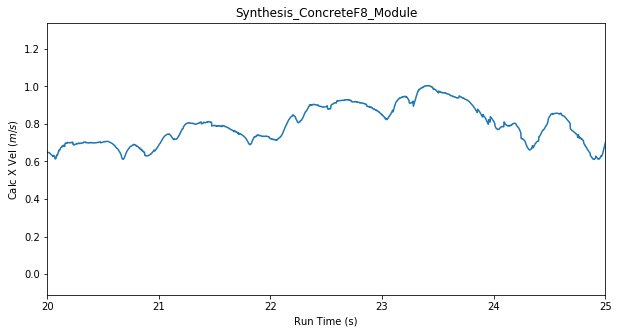

In [10]:
# Plot some raw data
plot_one(raw_datasets, dataset_labels[0], 'Run Time', 'Calc X Vel', xlim=(20, 25))

In [11]:
# Plot every dataset Z Accel and save images
#for label in dataset_labels:
#    plot_one(raw_datasets, label, 'Run Time', 'Z Accel', save_fig=True)

In [12]:
'''Compare two Pandas DataFrames by Epoch Time'''
def dataset_compare(dataset1, label1, dataset2, label2, dirn, t_offset=0, y_offset=0):
    plt.clf()
    fig, ax = plt.subplots(figsize=(20, 5))
    
    # Plot data with given y and t offsetson first dataset
    ax.plot(dataset1[label1]['Epoch Time'].apply(lambda t: t + t_offset), 
            dataset1[label1][dirn].apply(lambda y: y + y_offset), label=label1)
    ax.plot(dataset2[label2]['Epoch Time'], 
            dataset2[label2][dirn], label=label2)
    
    ax.set_xlabel('Epoch Time ($s$)')
    if 'Gyro' in dirn:
        ax.set_ylabel(dirn + ' ($rad/s$)')
    elif 'Accel' in dirn:
        ax.set_ylabel(dirn + ' ($m/s^2$)')
    
    ax.set_title(dirn + ' for ' + label1 + ' and ' + label2)
    
    # Plot offset info
    offset_text = 'Offsets\n'
    offset_text += ': t={}'.format(t_offset) + ', ' + 'y={}'.format(y_offset)
    ax.text(0.05, 0.05, s=offset_text, 
            horizontalalignment='left', verticalalignment='bottom', transform=ax.transAxes)
    
    ax.legend()
    plt.show()

In [13]:
# Compare Z Gyro data for each wheel in the same dataset
#dataset_compare(raw_datasets, 'Left_ConcreteStraight_Module',
#                raw_datasets, 'Right_ConcreteStraight_Module', 
#                dirn='Z Gyro')

In [14]:
'''Plot given x and y axes for every Pandas DataFrame in given array of datasets'''
def plot_all(_datasets, x_axis, y_axis, windowed=False, win_num=0, take_row=False):
    plt.clf()
    
    n_axes = len(_datasets)
    odd_axes = n_axes % 2 == 1
    
    rows = int((n_axes + 1) / 2)
    
    # Scale approriately
    if (odd_axes):
        fig = plt.figure(figsize=(n_axes*5, n_axes*3))          
    else:
        fig = plt.figure(figsize=(n_axes*5, n_axes*2))
    
    # Grid of subplots
    gs = gridspec.GridSpec(rows, 2)
        
    axes = []
    row, col = 0, 0
    
    for i, (label, dataset) in enumerate(_datasets.items()):
        # Take a whole row if odd num of axes
        if (i == n_axes-1 and odd_axes and take_row): 
            axes.append(fig.add_subplot(gs[row, :]))
        else:
            axes.append(fig.add_subplot(gs[row, col]))
        
        # Plot on new subplot
        if (windowed):
            axes[i].plot(dataset[win_num][x_axis], dataset[win_num][y_axis])
        else:
            axes[i].plot(dataset[x_axis], dataset[y_axis])
        
        axes[i].set_title(label)
        axes[i].set_xlabel(x_axis + ' (s)')
        
        if 'Gyro' in y_axis:
            axes[i].set_ylabel(y_axis + ' ($rad/s$)')
        elif 'Accel' in y_axis:
            axes[i].set_ylabel(y_axis + ' ($m/s^2$)')
        
        # Only go two columns wide
        col += 1
        if (col == 2):
            row += 1
            col = 0
        
    plt.subplots_adjust(hspace=0.35, wspace=0.15)
    plt.show()

<Figure size 432x288 with 0 Axes>

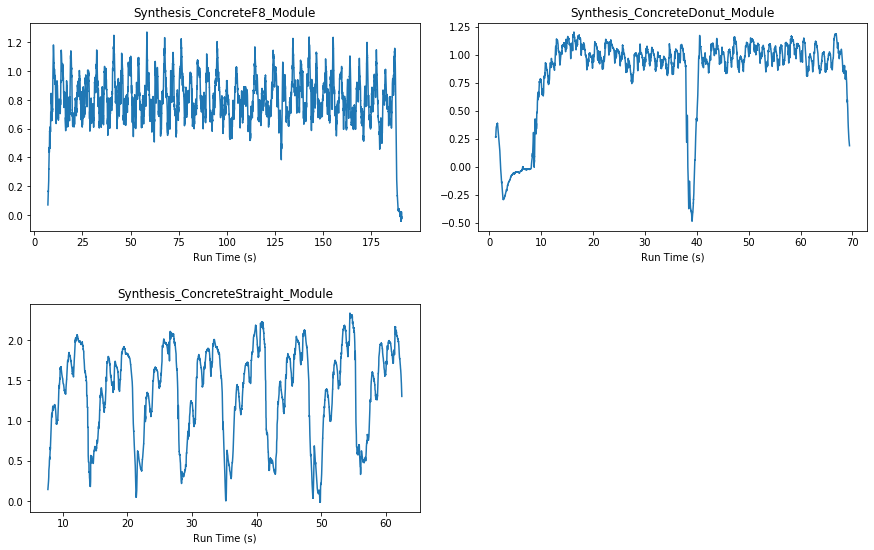

In [15]:
# Plot Z Accel of same dataset for different modules
datasets_to_plot = {label: dataset for label, dataset in raw_datasets.items() if 'Synthesis' in label and 'Concrete' in label}
plot_all(datasets_to_plot, x_axis='Run Time', y_axis='Calc X Vel')

### Part (c) - Converting Between Pandas and Numpy

In [16]:
'''Convert array of Pandas DataFrames to array of 2D Numpy array'''
def pd_to_np(pd_datasets, windowed=False):
    np_datasets = {}
    
    for label, dataset in pd_datasets.items():
        np_dataset = []
        
        # Return passed datasets if they are already NumPy ndarrays
        if type(dataset) is np.ndarray:
            print('Note: Already a NumPy array!')
            return pd_datasets
        
        # If windowed, convert individual windows to Pandas
        if (windowed):
            for window in dataset:
                np_dataset.append(window.as_matrix()) 
        else:
            np_dataset = dataset.to_numpy()
        
        np_datasets.update({label: np_dataset})
        
    return np_datasets

In [17]:
'''Convert array of 2D Numpy arrays to Pandas Data Frames'''
def np_to_pd(np_datasets, windowed=False):
    pd_datasets = {}
    
    for label, dataset in np_datasets.items():
        pd_dataset = []
        
        # Return passed datasets if they are already Pandas dataframes
        if type(dataset) is pd.DataFrame:
            print('Note: Already a Pandas dataframe!')
            return np_datasets
        
        # Use correct column names
        new_columns = get_columns(label)
            
        # If windowed, convert individual windows to Pandas
        if (windowed):
            for window in dataset:
                pd_dataset.append(pd.DataFrame(data=window, columns=new_columns))
                
        else:
            pd_dataset = pd.DataFrame(data=dataset, columns=new_columns)
            
        pd_datasets.update({label: pd_dataset})
    
    return pd_datasets

In [18]:
# Convert to NumPy
raw_datasets = pd_to_np(raw_datasets)

In [19]:
# Run to convert back to Pandas
#raw_datasets = np_to_pd(raw_datasets)

In [20]:
# Check if its constructed correctly
print('Number of datasets: {}'.format(len(raw_datasets)))
print('Shape of first dataset: {}'.format(raw_datasets[dataset_labels[0]].shape))

Number of datasets: 22
Shape of first dataset: (61239, 19)


#### Data Structure:

`Terrain Dataset Dictionary 
-> NP Array
---> Row = Datapoint, 
---> Col = Direction | Time`

## Part 2 - Preprocessing

In [21]:
'''Get relevant frequencies for given label based on whether its a frame or wheel dataset'''
def get_frequencies(label):
    # Sampling frequency (and thus cutoff frequency) varies between frame and wheel modules
    if 'Left' in label or 'Right' in label or 'Synthesis' in label:
        f_samp = 333.3 # Sampling frequency
        f_low = 60 # Low pass cutoff frequency
        f_high = 1 # High pass cutoff frequency
    elif 'Middle' in label:
        f_samp = 300 # Sampling frequency
        f_low = 55 # Low pass cutoff frequency
        f_high = 1 # High pass cutoaff frequency
    else:
        raise Exception('Unknown label format')
        
    return f_samp, f_low, f_high

In [22]:
'''Get window size based on whether label is for a frame or wheel dataset'''
def get_window_size(label):
    if 'Left' in label or 'Right' in label or 'Synthesis' in label:
        window_size = 333
    elif 'Middle' in label:
        window_size = 300
    else:
        raise Exception('Unknown label format')
    return window_size

In [23]:
def get_n_data_col(label):
    if 'Synthesis' in label:
        n_col = 17
    elif 'Left' in label or 'Right' in label or 'Middle' in label:
        n_col = 6
    else:
        raise Exception('Unknown label format')
    return n_col

### Part (a) - Butterworth Filtering

Butterworth filters can be high-pass/low-pass/bandpass, and attempt to have maximally flat frequency response in bandpass.

Changing the *cutoff frequency* of the filter affects the smoothness of the graph and amount of ringing. 

Changing the *order* of the filter can have significant effects on smoothness depending on the cutoff frequency. 

**Nominally set to 30 % of Nyquist Freq**

In [24]:
# Filtered datasets dictionary
datasets = {}

for label, raw_dataset in raw_datasets.items():
    
    # Sampling rates are not consistent across all datasets
    f_samp, f_low, f_high = get_frequencies(label)
    
    # Get normalized frequencies
    w_low = f_low / (f_samp / 2) 
    w_high = f_high / (f_samp / 2)

    # Get Butterworth filter parameters
    b_butter, a_butter = signal.butter(N=4, Wn=w_low, btype='low')
    
    # Number of columns containing data
    n_data_col = get_n_data_col(label)
    
    # Filter all the data columns
    dataset = np.copy(raw_dataset)
    for i in range(n_data_col):
        dataset[:, i] = signal.filtfilt(b_butter, a_butter, raw_dataset[:, i])
        
    datasets.update({label: dataset})

<Figure size 432x288 with 0 Axes>

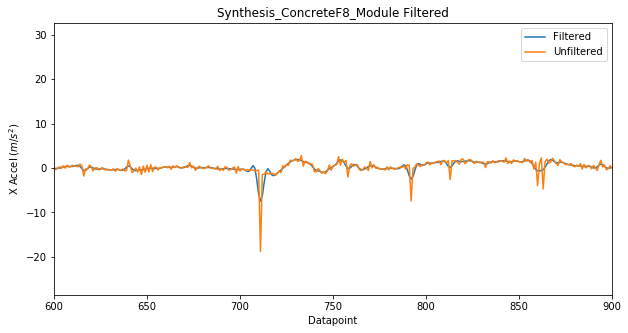

In [25]:
# Compare filtered and unfiltered
plt.clf()
plt.figure(figsize=(10, 5))
plt.plot(datasets[dataset_labels[0]][:, 0], label='Filtered')
plt.plot(raw_datasets[dataset_labels[0]][:, 0], label='Unfiltered')
plt.xlim(600, 900)
plt.legend()
plt.xlabel('Datapoint')
plt.ylabel('X Accel ($m/s^2$)')
plt.title(dataset_labels[0] + ' Filtered')
plt.show()

In [26]:
## Check construction
print('Num filtered datasets: {}'.format(len(datasets)))
print('Shape of first filtered dataset: {}'.format(datasets[dataset_labels[0]].shape))

Num filtered datasets: 22
Shape of first filtered dataset: (61239, 19)


In [27]:
# Verify we can convert back to Pandas
np_to_pd(datasets, windowed=False)[dataset_labels[0]].head()

,Calc X Accel,Calc X Vel,Calc Z Gyro,Left X Accel,Left Y Accel,Left Z Accel,Left XY Accel,Left X Gyro,Left Y Gyro,Left Z Gyro,Right X Accel,Right Y Accel,Right Z Accel,Right XY Accel,Right X Gyro,Right Y Gyro,Right Z Gyro,Run Time,Epoch Time
0,2.697501,0.069381,0.180964,-11.237520,0.298095,-0.662951,11.241473,-0.226225,0.008984,0.075696,-0.721443,10.190208,-1.057142,9.852820,-0.021146,0.706881,-2.790185,7.057,1.564507e+09
1,1.244522,0.070853,0.183068,-11.210105,0.253573,-0.580567,11.213037,-0.224790,0.009973,0.078832,-0.756693,10.293036,-0.778257,9.843634,-0.018743,0.706608,-2.783271,7.060,1.564507e+09
2,0.362861,0.072292,0.185079,-11.204017,0.230769,-0.541774,11.206425,-0.226102,0.010200,0.081938,-0.842674,10.340766,-0.570062,9.840118,-0.024268,0.703993,-2.777305,7.063,1.564507e+09
3,0.178290,0.073710,0.186977,-11.226735,0.236605,-0.548565,11.229274,-0.230028,0.009373,0.085071,-0.987630,10.324424,-0.492187,9.845387,-0.036636,0.698854,-2.772019,7.066,1.564507e+09
4,0.374745,0.075140,0.188799,-11.263414,0.256317,-0.563000,11.266409,-0.233979,0.007933,0.088314,-1.153005,10.268382,-0.531823,9.859113,-0.047793,0.692750,-2.766285,7.069,1.564507e+09


<Figure size 432x288 with 0 Axes>

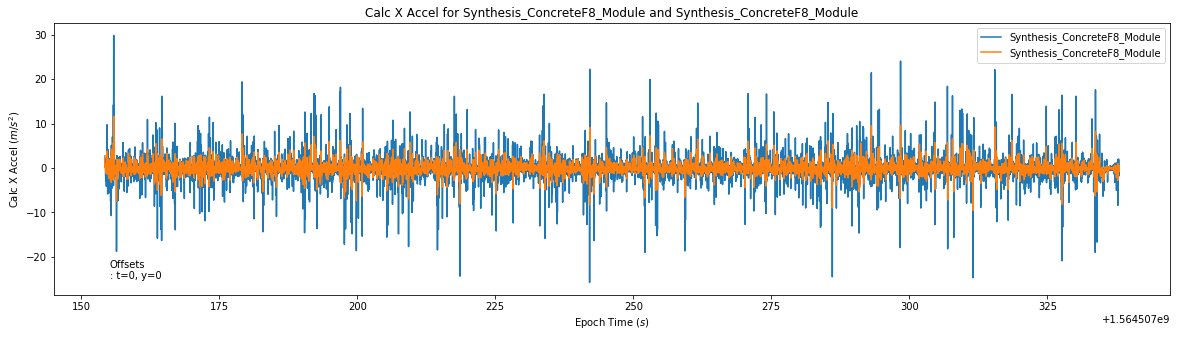

In [28]:
# Again compare filtered and unfiltered data
dataset_compare(np_to_pd(raw_datasets), dataset_labels[0], 
                np_to_pd(datasets), dataset_labels[0], 'Calc X Accel')

### Part (b) - Further Time Domain Visualization

In [29]:
'''Compare Z Gyro of frame to calculated value off of two wheels'''
def gyro_compare(dataset, label, xlim=None):
    plt.clf()
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Calculate Z Gyro off of wheels
    r_wheel = 0.30
    d_base = 0.54
    calc = (r_wheel / d_base)*(-1 * dataset['Left_' + label]['Z Gyro'] - dataset['Right_' + label]['Z Gyro'])
    calc = np.reshape(calc, dataset['Right_' + label]['Epoch Time'].shape)
    
    # Plot actual frame gyro, calculated frame gyro, and actual wheel gyro
    ax.plot(dataset['Middle_' + label]['Epoch Time'], dataset['Middle_' + label]['Z Gyro'], 
            label='Actual Frame')
    ax.plot(dataset['Right_' + label]['Epoch Time'], calc, label='Calculated Frame')
    ax.plot(dataset['Left_' + label]['Epoch Time'], dataset['Left_' + label]['Z Gyro'], 
            label='Actual L Wheel')
    ax.plot(dataset['Right_' + label]['Epoch Time'], dataset['Right_' + label]['Z Gyro'],
            label='Actual R Wheel')
    
    # Other figure stuff
    ax.set_xlabel('Epoch Time ($s$)')
    ax.set_ylabel('Z Gyro ($m/s^2$)')
    ax.set_title('Comparing Actual to Calculated Z Gyro Data')
    
    if xlim:
        start_time = dataset['Middle_' + label]['Epoch Time'][0]
        ax.set_xlim(xlim[0] + start_time, xlim[1] + start_time)
    ax.legend()
    plt.show()

In [30]:
#gyro_compare(np_to_pd(datasets), 'ConcreteDonutKevin_Module', xlim=(20, 40))

### Part (c) - Integrating Data from Three Modules

In [ ]:
# Go through Left and Right datasets and integrate into one dataset
'''
for terrain in terrains:
    for movement in movements:
        # Identifier at end of label
        label_suffix = terrain + movement + '_Module'
        
        # Set index to epoch time for easier time alignment
        left = datasets['Left_' + label_suffix].set_index('Epoch Time')
        right = datasets['Right_' + label_suffix].set_index('Epoch Time')
        middle = datasets['Middle_' + label_suffix + '6050'].set_index('Epoch Time')
        synthesis = datasets['Synthesis_' + label_suffix].set_index('Epoch Time')
        
        # Join the wheel data columns, only where they overlap in Epoch Time
        dataset_wheels = pd.concat([left, right], axis=1, join='inner')
        dataset_wheels = dataset_wheels.reset_index()
        
        # Save as a csv and add to dataset dictionary
        wheels_label = 'Wheels_' + label_suffix
        dataset_wheels.to_csv('imu_data/' + wheels_label + '.csv', index=False)
        datasets.update({wheels_label: dataset_wheels})
        
        # Join data from all the "placements", only where they overlap in Epoch Time
        dataset_all = pd.concat([left, right, middle, synthesis], axis=1, join='inner')
        dataset_all = dataset_all.reset_index()
        
        # Save as csv and add to dictionary
        all_label = 'All_' + label_suffix
        dataset_all.to_csv('imu_data/' + all_label + '.csv')
        datasets.update({all_label: dataset_all})
'''

In [33]:
# Only process new integrated data for now
#datasets = {label: dataset for label, dataset in datasets.items() if 'All' in label or 'Wheels' in label}
#dataset_labels = list(datasets.keys())

## Part 3 - Time Windows

### Part (a) - Creating Time Windowed Data

In [35]:
datasets_windowed = {}

# Trim excess datapoints, then split into windows
for label, dataset in datasets.items():
    window_size = get_window_size(label)
    n_windows = int(len(dataset) / window_size) # Note: Integer floor
    n_points = n_windows * window_size
    
    dataset_windowed = np.resize(dataset, (n_points, dataset.shape[1]))
    dataset_windowed = np.split(dataset_windowed, n_windows, axis=0)
    
    datasets_windowed.update({label: dataset_windowed})

In [36]:
# Check if its constructed correctly
print('Num windowed datasets: {}'.format(len(datasets_windowed)))
print('Num of windows in first dataset: {}'.format(len(datasets_windowed[dataset_labels[0]])))
print('Shape of individual window: {}'.format(datasets_windowed[dataset_labels[0]][0].shape))

Num windowed datasets: 22
Num of windows in first dataset: 183
Shape of individual window: (333, 19)


In [37]:
# Try out pandas conversion again
np_to_pd(datasets_windowed, windowed=True)[dataset_labels[0]][0].tail()

,Calc X Accel,Calc X Vel,Calc Z Gyro,Left X Accel,Left Y Accel,Left Z Accel,Left XY Accel,Left X Gyro,Left Y Gyro,Left Z Gyro,Right X Accel,Right Y Accel,Right Z Accel,Right XY Accel,Right X Gyro,Right Y Gyro,Right Z Gyro,Run Time,Epoch Time
328,0.303441,0.583041,0.941962,-9.880489,4.627848,-0.070163,10.914256,-0.851302,0.447677,1.146205,1.989967,-9.710777,-0.387884,10.134200,0.227077,-1.237182,-3.426637,8.041,1.564507e+09
329,0.312721,0.583979,0.941030,-9.858928,4.660811,0.076622,10.907625,-0.850184,0.452884,1.150207,2.252017,-10.024048,-0.042039,10.196462,0.239137,-1.230667,-3.423666,8.044,1.564507e+09
330,0.269579,0.584788,0.939710,-9.875070,4.720327,0.145636,10.946472,-0.843805,0.454322,1.154112,2.473589,-10.099675,0.132058,10.242201,0.250741,-1.225630,-3.419511,8.047,1.564507e+09
331,0.270364,0.585599,0.937811,-9.931195,4.743644,0.137295,11.006403,-0.834351,0.453289,1.158535,2.607285,-9.858972,0.006405,10.202074,0.261789,-1.219808,-3.414184,8.050,1.564507e+09
332,0.336131,0.586607,0.935432,-10.004946,4.718995,0.096354,11.062328,-0.827315,0.453651,1.164050,2.697098,-9.474264,-0.241423,10.041570,0.272096,-1.211275,-3.408012,8.053,1.564507e+09


<Figure size 432x288 with 0 Axes>

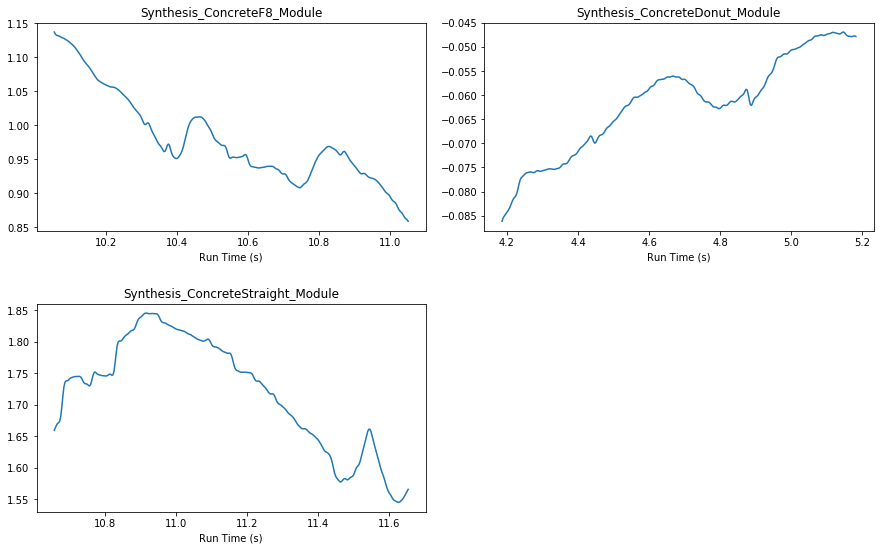

In [38]:
# Plot the first time window
datasets_to_plot = {label: dataset for label, dataset in datasets_windowed.items() if 'Concrete' in label}
plot_all(np_to_pd(datasets_to_plot, windowed=True), 
         x_axis='Run Time', y_axis='Calc X Vel', windowed=True, win_num=3)

#### Data Structure

`Terrain Dataset Dictionary
-> Data Window List
---> NP Array
-----> Row = Datapoint
-----> Col = Direction | Time`

## Part 4 - Transforms

In [39]:
'''Plot tranform of given direction and window of a windowed dataset dictionary'''
def plot_set_transforms(datasets_transformed, dirn, win_num, transform_name):
    plt.clf()
    plt.figure(figsize=(12, 8))
    
    # Plot all the FFTs in one figure overlaid
    for label, dataset in datasets_transformed.items():
        plt.plot(dataset[win_num][:, -1], dataset[win_num][:, dirn], 
                 label=label)
    plt.legend()

    plt.xlabel('Frequency ($Hz$)')
    if (transform_name == 'FFT'):
        plt.ylabel('Amplitude (Normalized to Window Size)')
    elif (transform_name == 'PSD'):
        plt.ylabel('Amplitude (Log-Scaled)')

    plt.title(transform_name +' of ' + get_columns(label)[dirn] + ', Window {}')
    plt.show()

### Part (a) - FFT

In [40]:
datasets_fft = {}
N_BINS_OVER_CUTOFF = 5 # Number of frequency bins past the cutoff frequency to include

# Find the FFT of each column of each data window of each dataset
for label, dataset in datasets_windowed.items():
    dataset_fft = []
    
    for window in dataset:
        # Sampling frequency dependent on device
        f_samp, f_low, f_high = get_frequencies(label)
        
        # Number of columns of data different for synthesis data
        n_data_col = get_n_data_col(label)
        
        # Only include frequency bins up to and a little bit past the cutoff frequency
        # Everything past that is useless because its the same on all terrains
        window_size = get_window_size(label)
        n_bins = int(window_size / f_samp * f_low) + N_BINS_OVER_CUTOFF
        window_fft = np.zeros((n_bins, n_data_col))
        
        for i in range(n_data_col):
            # FFT is normalized to window size, to ensure consistency between different size choices
            window_fft[:, i] = np.resize(np.abs(np.divide(np.fft.fft(window[:, i]), window_size)), n_bins)
            
        # Get positive frequency bins for given FFT parameters
        freq_col = np.transpose([np.resize(np.fft.fftfreq(window_size, 1 / f_samp), n_bins)])
        
        # Append the frequency column
        window_fft = np.append(window_fft, freq_col, axis=1)
        dataset_fft.append(window_fft)
        
    datasets_fft.update({label + 'FFT': dataset_fft})

In [41]:
# Check again if its constructed correctly
print('Num of FFT\'d windowed datasets: {}'.format(len(datasets_fft)))
print('Num of FFT\'d windows in first dataset: {}'.format(len(datasets_fft[dataset_labels[4]+'FFT'])))
print('Shape of FFT\'d individual window: {}'.format(datasets_fft[dataset_labels[4]+'FFT'][0].shape))

# Pandas conversion
np_to_pd(datasets_fft, windowed=True)[dataset_labels[0]+'FFT'][0].head()

Num of FFT'd windowed datasets: 22
Num of FFT'd windows in first dataset: 68
Shape of FFT'd individual window: (64, 18)


,Calc X Accel,Calc X Vel,Calc Z Gyro,Left X Accel,Left Y Accel,Left Z Accel,Left XY Accel,Left X Gyro,Left Y Gyro,Left Z Gyro,Right X Accel,Right Y Accel,Right Z Accel,Right XY Accel,Right X Gyro,Right Y Gyro,Right Z Gyro,Frequency
0,0.527001,0.326964,0.652687,10.975711,1.862471,0.401447,11.215207,0.678685,0.157169,0.533104,5.485298,1.093576,0.724800,9.980674,0.604554,0.301704,3.238749,0.000000
1,0.089052,0.096641,0.170339,0.166585,0.641636,0.044620,0.018353,0.147478,0.074647,0.187922,2.270683,4.611326,0.236203,0.062758,0.319319,0.499645,0.342374,1.000901
2,0.078857,0.036262,0.047824,0.104149,0.386405,0.028559,0.010317,0.039479,0.034392,0.081008,0.536923,1.649849,0.045108,0.035031,0.051998,0.141310,0.086883,2.001802
3,0.111703,0.033681,0.046690,0.082814,0.305309,0.042439,0.008472,0.043827,0.025016,0.073022,0.218911,0.821100,0.129463,0.017292,0.038660,0.092305,0.064020,3.002703
4,0.133268,0.024777,0.046501,0.078729,0.249510,0.049308,0.022879,0.039545,0.020783,0.043194,0.369818,0.983193,0.113236,0.032926,0.016604,0.073524,0.069554,4.003604


<Figure size 432x288 with 0 Axes>

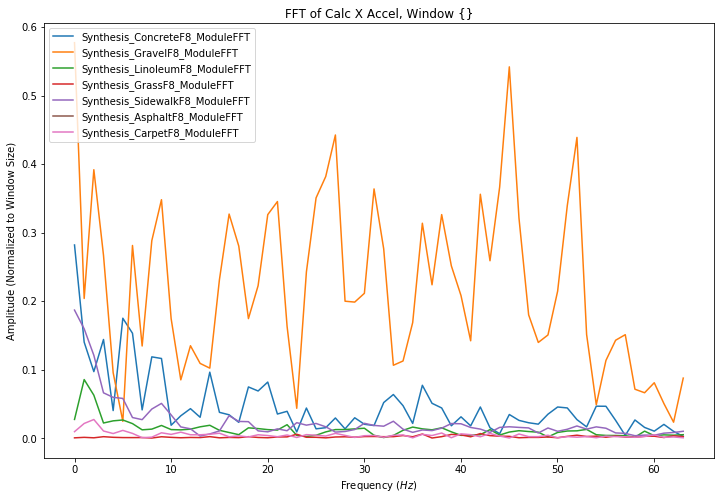

In [42]:
# Plot Middle Z Accel of 10th window
ffts_to_plot = {label: dataset for label, dataset in datasets_fft.items() if 'Synthesis' in label and 'Straight' not in label and 'Donut' not in label}
plot_set_transforms(ffts_to_plot, win_num=3, dirn=0, transform_name='FFT')

**The number of frequency bins is dependent on window size, and it seems to affect amplitude too.**

<Figure size 432x288 with 0 Axes>

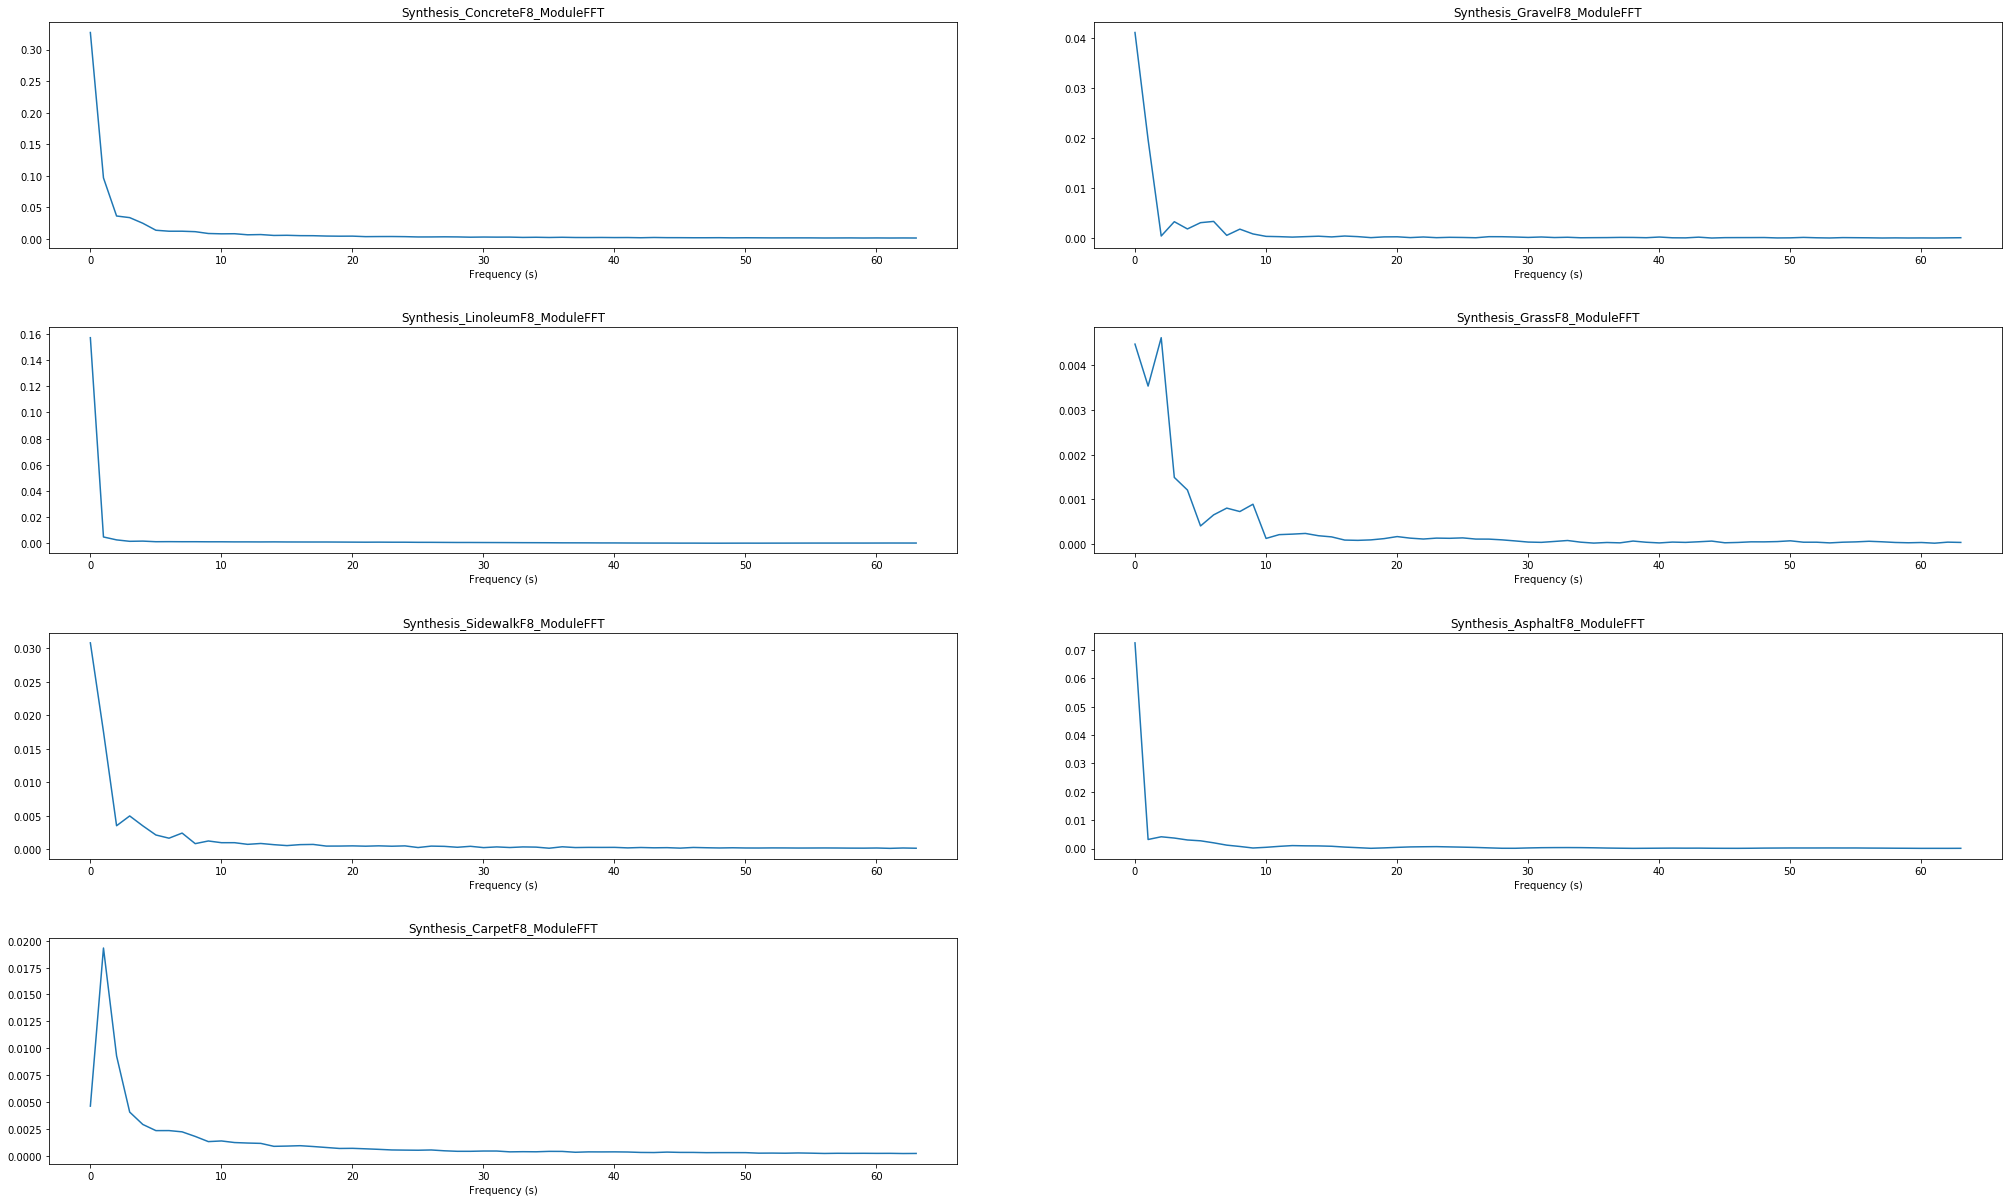

In [43]:
# Plot all the Frame FFTs for 0th window
plot_all(np_to_pd(ffts_to_plot, windowed=True), x_axis='Frequency', y_axis='Calc X Vel', windowed=True)

### Part (b) - PSD

In [44]:
datasets_psd = {}
datasets_psd_log = {}

# Find the PSD and log(PSD) of each column of each data window of each dataset
for label, dataset in datasets_windowed.items():
    dataset_psd = []
    dataset_psd_log = []
    
    for window in dataset:
        # Frequencies depedent on dataset and device used
        f_samp, f_low, f_high = get_frequencies(label)
        
        # Number of columns of data different for synthesis data
        n_data_col = get_n_data_col(label)
        
        # Only include frequency bins up to and a little bit past the cutoff frequency
        # Everything past that is useless because its the same on all terrains
        window_size = get_window_size(label)
        n_bins = int(window_size / f_samp * f_low) + N_BINS_OVER_CUTOFF
        window_psd = np.zeros((n_bins, n_data_col))
        window_psd_log = np.zeros((n_bins, n_data_col))
        
        # Calculate PSD for each axes
        for i in range(n_data_col):
            # Normalized PSD - Returns frequencies and power density
            freq, Pxx = signal.periodogram(window[:, i], f_samp)
            window_psd[:, i] = np.resize(Pxx[1:], n_bins)
            
            # Calculate log10 of PSD, replacing points where PSD = 0 with 0 to avoid division by 0
            for j in range(len(window_psd[:, i])):
                if (window_psd[j, i] == 0):
                    window_psd_log[j, i] = 0
                else:
                    window_psd_log[j, i] = np.log10(window_psd[j, i])
            
        # Append freq column
        freq_col = np.transpose([np.resize(freq[:-1], n_bins)])
        window_psd = np.append(window_psd, freq_col, axis=1)
        window_psd_log = np.append(window_psd_log, freq_col, axis=1)
        
        dataset_psd.append(window_psd)
        dataset_psd_log.append(window_psd_log)
        
    datasets_psd.update({label + 'PSD': dataset_psd})
    datasets_psd_log.update({label +'PSDLog': dataset_psd_log})

In [45]:
# Check again if its constructed correctly
print('Num PSD\'d windowed datasets: {}'.format(len(datasets_psd)))
print('Num of PSD\'d windows in first dataset: {}'.format(len(datasets_psd[dataset_labels[0]+'PSD'])))
print('Shape of PSD\'d individual window: {}'.format(datasets_psd[dataset_labels[0]+'PSD'][0].shape))

Num PSD'd windowed datasets: 22
Num of PSD'd windows in first dataset: 183
Shape of PSD'd individual window: (64, 18)


<Figure size 432x288 with 0 Axes>

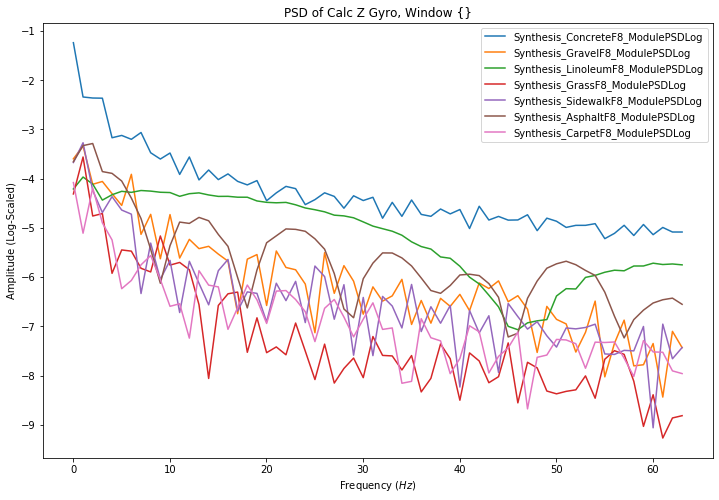

In [46]:
# Plot Z Accel of 0th window
psds_to_plot = {label: dataset for label, dataset in datasets_psd_log.items() if 'Synthesis' in label and 'Power' not in label and 'Straight' not in label and 'Donut' not in label}
plot_set_transforms(psds_to_plot, win_num=0, dirn=2, transform_name='PSD')

<Figure size 432x288 with 0 Axes>

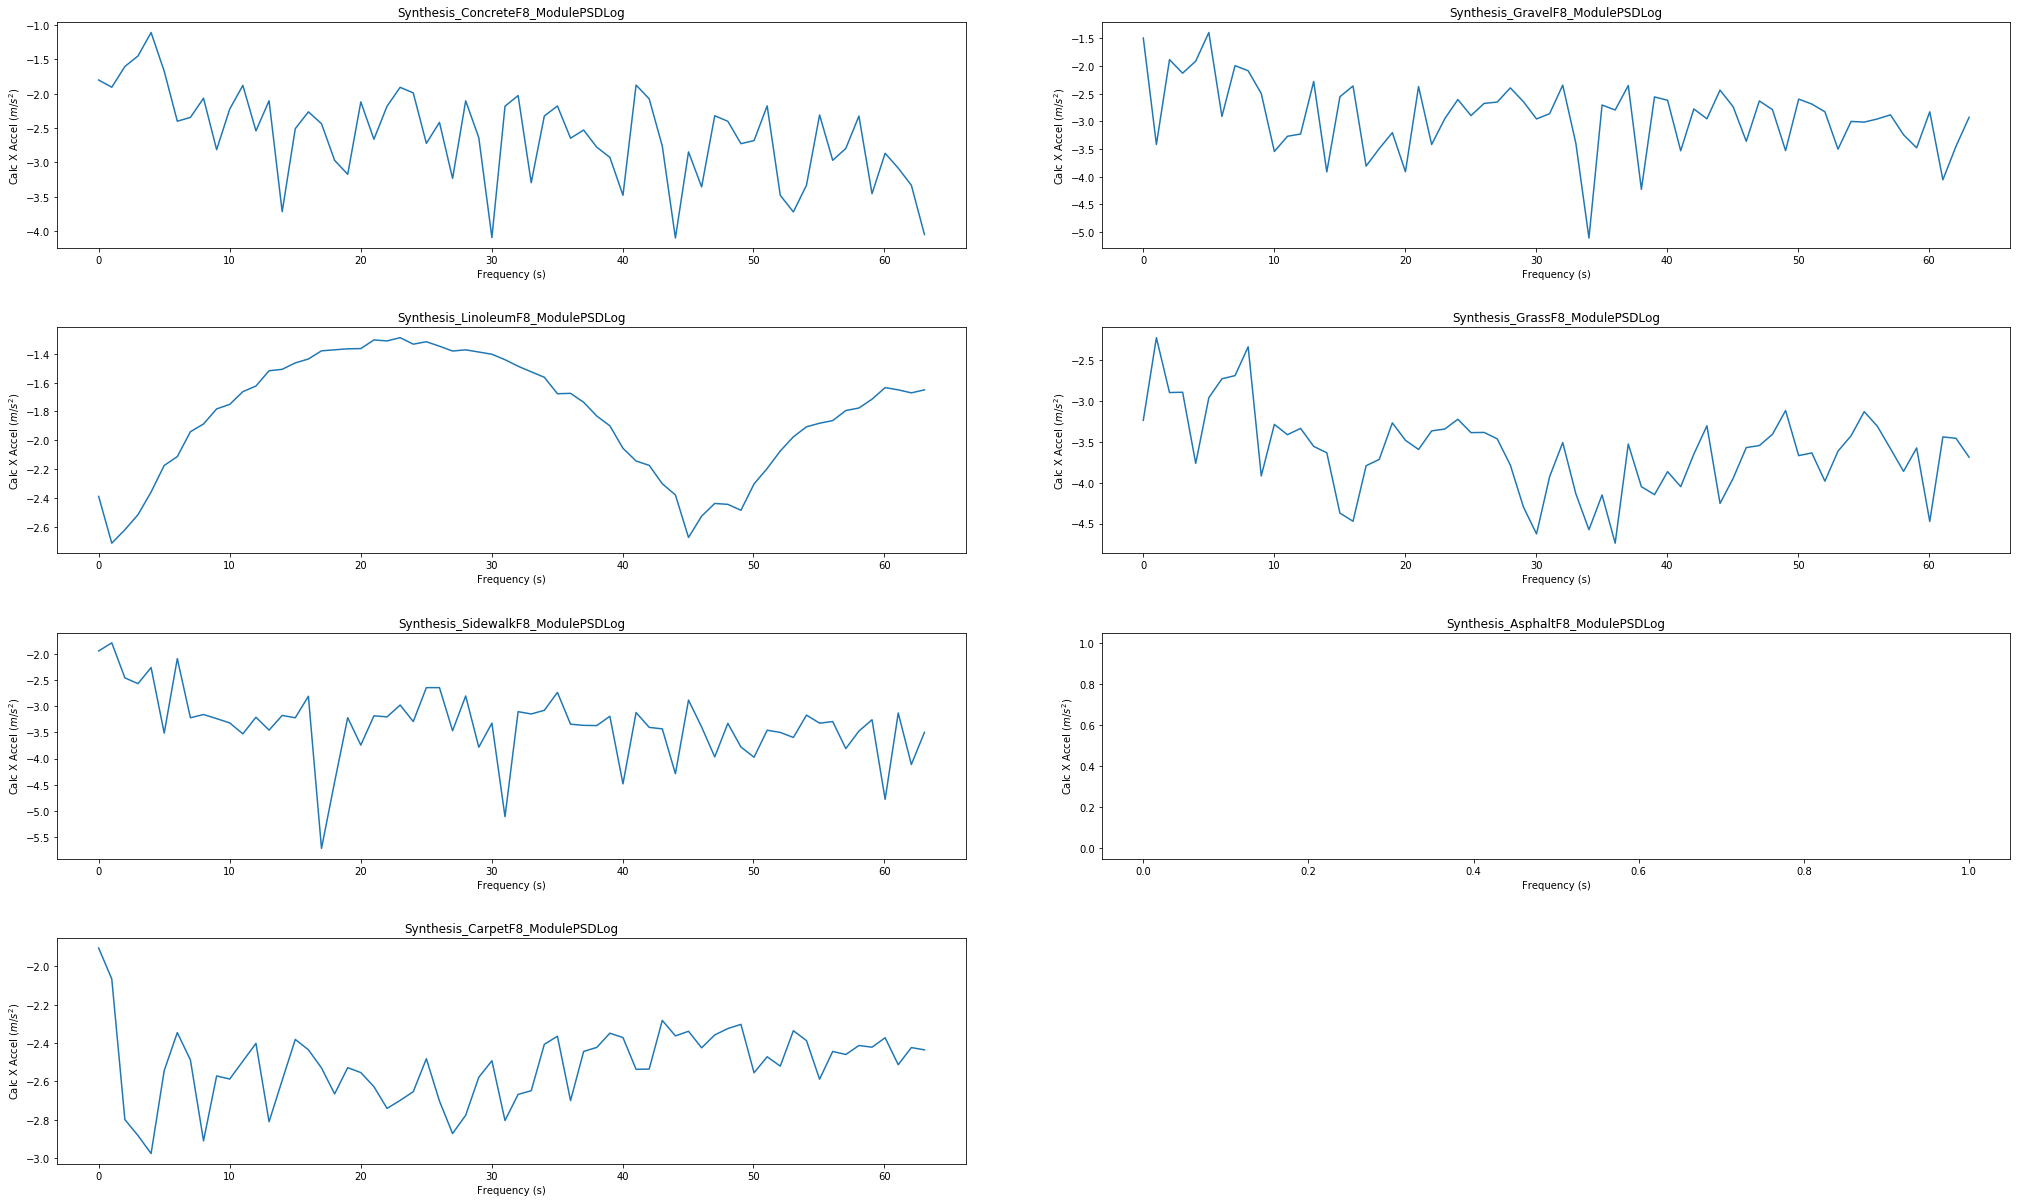

In [47]:
# Plot all PSDs of Z Accel for 0th window
plot_all(np_to_pd(psds_to_plot, windowed=True), x_axis='Frequency', y_axis='Calc X Accel', windowed=True)

#### Data Structure:

`Labelled Terrain Dataset
-> Time Window
---> 2D NumPy Array
-----> Row = Transform Value for Frequency
-----> Col = Dirn | Frequency`

### Part (c) - 3D Visualization

In [48]:
'''Plot the set transforms in 3d'''
def plot_transforms_3d(datasets_transformed, win_num, dirn, transform_name):
    plt.clf()
    fig = plt.figure(figsize=(10, 8))
    ax = fig.gca(projection='3d')
    
    # Specific to FFT or PSD
    if transform_name == 'FFT':
        z_lim = (0, 1.6)
        ax.set_zlim(z_lim[0], z_lim[1])
        ax.set_zlabel('Amplitude (Normalized to Window Size)')
        
    elif transform_name == 'PSD':
        z_lim = (-10, -30)
        ax.set_zlim(z_lim[0], z_lim[1])
        ax.set_zlabel('Amplitude (Log-Scaled)')
    
    n_datasets = len(datasets_transformed)
    
    # Change y axis to corespond with terrain labels
    ax.set_ylim(0.5, n_datasets+0.5)
    subset = np.arange(0, n_datasets, dtype=int)
    ax.set_yticks(np.add(subset, 1.5))
    y_labels = [get_terrain_name(get_terrain_num(key)) for key in datasets_transformed.keys()]
    ax.set_yticklabels(y_labels)
    
    ax.set_xlabel('Frequency ($Hz$)')
    
    # Bar graph paremeters
    width = depth = 0.75
    
    # TODO: Sort by max amplitude
    # Plot each dataset FFT
    for i, (label, dataset) in enumerate(datasets_transformed.items()):
        # To plot
        x = dataset[win_num][:, -1]
        y = [i+1]
        top = dataset[win_num][:, dirn]
        
        # Specific to transform
        bot = np.full(top.shape, z_lim[0])
        ax.bar3d(x, y, bot, width, depth, top, alpha=0.8)
        
        # TODO: Make this nicer
        ax.set_title(transform_name + ' of ' + get_columns(label)[dirn] + ', Window {}')
    
    plt.show()

<Figure size 432x288 with 0 Axes>

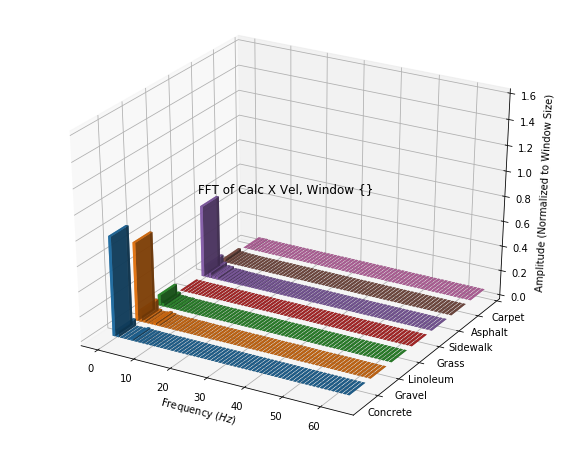

In [49]:
# Plot 3D Z Accel FFT of 0th window
ffts_to_plot = {label: dataset for label, dataset in datasets_fft.items() if 'Synthesis' in label and 'Straight' not in label and 'Donut' not in label}
plot_transforms_3d(ffts_to_plot, win_num=4, dirn=1, transform_name='FFT')

TypeError: '(slice(None, None, None), -1)' is an invalid key

<Figure size 432x288 with 0 Axes>

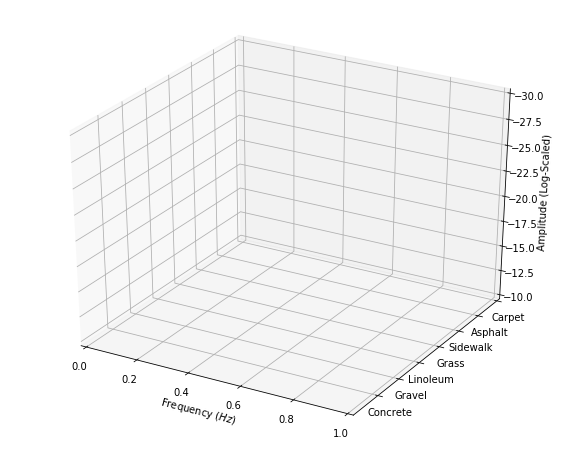

In [88]:
# Plot 3D Z Accel PSD of 0th window
psds_to_plot = {label: dataset for label, dataset in datasets_psd_log.items() if 'Synthesis' in label and 'Straight' not in label and 'Donut' not in label }
plot_transforms_3d(psds_to_plot, win_num=4, dirn=1, transform_name='PSD')

### Part (d) - Spectograms

In [51]:
'''Plot a spectogram of data'''
def plot_spectogram(set_label, dirn, size):
    # Get sampling frequency for label
    f_samp, f_low, f_high = get_frequencies(set_label)
    
    plt.clf()
    plt.figure(figsize=(12, 8))
    
    # Compute spectogram directly using time series data
    plt.specgram(datasets[set_label][:, dirn], NFFT=size, Fs=f_samp)
    plt.title('Spectrogram of {} for {}'.format(get_columns(set_label)[dirn], set_label))
    plt.xlabel('Data Window')
    plt.xticks(label=np.arange(0, len(datasets_windowed[set_label])))
    plt.ylabel('Frequency ($Hz$)')
    
    plt.show()

<Figure size 432x288 with 0 Axes>

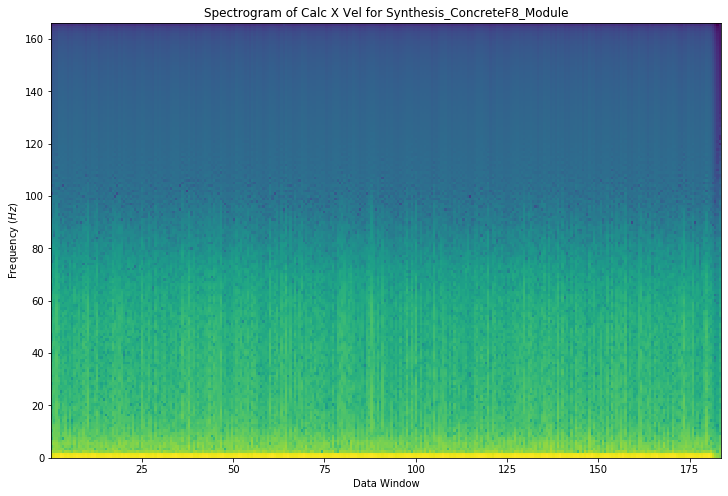

In [52]:
plot_spectogram(dataset_labels[0], dirn=1, size=get_window_size(dataset_labels[0]))

## Part 5 - Feature Extraction

#### Extract possibly relevant features (e.g. Mean, Min, Skew) from each data window

In [53]:
# Feature extraction functions

# For small float values
EPSILON = 0.00001

'''L2 norm of an array'''
def l2norm(array):
    return np.linalg.norm(array, ord=2)

'''Correlation of an array with itself'''
def autocorr(array):
    return np.correlate(array, array)[0]

'''Root mean squared of an array'''
def rms(array):
    return np.sqrt(np.mean(array ** 2))

'''Zero crossing rate of an array as a fraction of total size of array'''
def zcr(array):
    # Locations where array > 0, put -1 and 1 for rising/falling,
    # divide by total datapoints
    return len(np.nonzero(np.diff(array > 0))[0]) / len(array)

'''Mean square frequency'''
def msf(freqs, psd_amps):
    num = np.sum(np.multiply(np.resize(freq, len(psd_amps)), np.power(psd_amps, 2)))
    denom = np.sum(psd_amps)
    
    # In case zero amplitude transform is ecountered
    if denom <= EPSILON:
        return EPSILON
    
    return np.divide(num, denom)

'''Root mean square frequency'''
def rmsf(freqs, psd_amps):
    return np.sqrt(msf(freqs, psd_amps))

'''Frequency center'''
def fc(freqs, psd_amps):
    num = np.sum(np.multiply(np.resize(freq, len(psd_amps)), psd_amps))
    denom = np.sum(psd_amps)
    
    # In case zero amplitude transform is ecountered
    if denom <= EPSILON:
        return EPSILON
    
    return np.divide(num, denom)

'''Variance frequency'''
def vf(freqs, psd_amps):
    return msf(freqs, psd_amps) - fc(freqs, psd_amps) ** 2

'''Root variance frequency'''
def rvf(freqs, psd_amps):
    return np.sqrt(msf(freqs, psd_amps))

In [54]:
'''Extract given features from everything in dataset'''
def feature_all(features, datasets, regular=True):
    datasets_feat = {}
    
    # Calculate features for each window of each column of each dataset
    for label, dataset in datasets.items():
        directions = {}
        n_data_col = get_n_data_col(label)
        
        # Loop over data columns
        for i, direction in enumerate(get_columns(label)[:n_data_col]):
            feats = {}
            
            if (regular):
                '''Execute a function over all windows'''
                def function_all_windows(function):
                    feat_in_window = []
                    
                    for window in dataset:
                        feat_in_window.append(function(window[:, i]))
                    
                    return feat_in_window
                    
            else:
                '''Alternate defintion for frequency functions'''
                def function_all_windows(function):
                    feat_in_window = []
                    
                    for window in dataset:
                        feat_in_window.append(function(window[:, -1], window[:, i]))
                    
                    return feat_in_window
                    
                    
            # Execute every function over all windows    
            for feat_name, feat_func in features.items():
                feats.update({feat_name: function_all_windows(feat_func)})
            
            directions.update({direction: pd.DataFrame.from_dict(feats)})

        datasets_feat.update({label.replace('PSD', ''): directions})
    
    return datasets_feat

In [55]:
'''Plot a feature on all terrains for each time window'''
def plot_set_features(datasets_feat, dirn, feat_name, placement_name, ylim=None, xlim=None):
    plt.clf()
    plt.figure(figsize=(10,8))
    
    for label, dataset in datasets_feat.items():
        plt.plot(dataset[dirn][feat_name], label=label)
        
    if ylim is not None:
        plt.ylim(ylim[0], ylim[1])
    if xlim is not None:
        plt.xlim(xlim[0], xlim[1])
    
    plt.ylabel(feat_name)
    plt.xlabel('Window #')
    plt.title(placement_name + ' ' + dirn)
    plt.legend()
    plt.show()

### Part (a) - Time Domain Features

In [56]:
# Time domain feature functions and names
time_features = {'Mean': np.mean, 'Std Dev': np.std,  'L2 Norm': l2norm, 'Autocorrelation': autocorr, 
                 'Max': np.amax, 'Min' : np.amin, 'Root Mean Squared': rms, 'Zero Crossing Rate': zcr, 
                 'Skew': stats.skew, 'Excess Kurtosis': stats.kurtosis} 

# Create array of features of each window for each dataset and direction
datasets_feat_time = feature_all(time_features, datasets_windowed)

In [57]:
# Check if its constructed correctly and print some info
print('Num datasets: {}'.format(len(datasets_feat_time)))
print('Num directions: {}'.format(len(datasets_feat_time[dataset_labels[0]])))
print('Shape of first dataset first direction: {}'.format(datasets_feat_time[dataset_labels[0]]['Calc X Accel'].shape))

Num datasets: 22
Num directions: 17
Shape of first dataset first direction: (183, 10)


<Figure size 432x288 with 0 Axes>

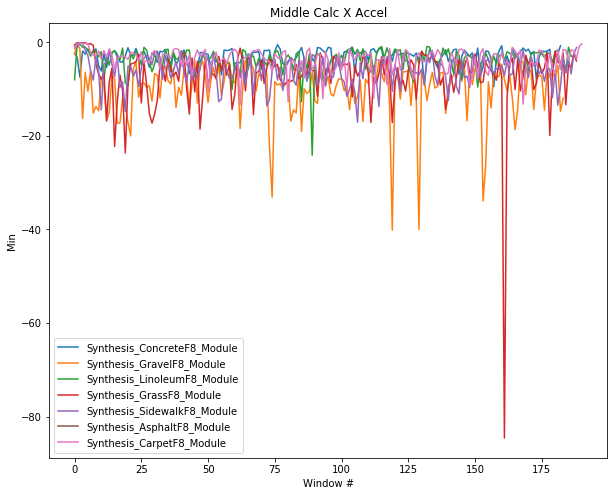

In [58]:
# Plot Min of frame Z Accel
feat_datasets_to_plot = {label: dataset for label, dataset in datasets_feat_time.items() if 'Synthesis' in label in label and 'Straight' not in label and 'Donut' not in label}
plot_set_features(feat_datasets_to_plot, dirn='Calc X Accel', feat_name='Min', placement_name='Middle')

### Part (b) - Frequency Domain Features

In [59]:
# Frequency domain feature functions and names
freq_features = {'Mean Square Frequency': msf, 'Root Mean Square Frequency': rmsf, 'Frequency Center': fc, 
                 'Variance Frequency': vf, 'Root Variance Frequency': rvf}

# Create array of features of each window for each dataset and direction
datasets_feat_freq = feature_all(freq_features, datasets_psd, regular=False)

In [60]:
# Check if its constructed correctly and print some info
print('Num datasets: {}'.format(len(datasets_feat_freq)))
print('Num directions: {}'.format(len(datasets_feat_freq[dataset_labels[0]])))
print('Shape of one direction: {}'.format(datasets_feat_freq[dataset_labels[0]]['Calc X Vel'].shape))

Num datasets: 22
Num directions: 17
Shape of one direction: (183, 5)


<Figure size 432x288 with 0 Axes>

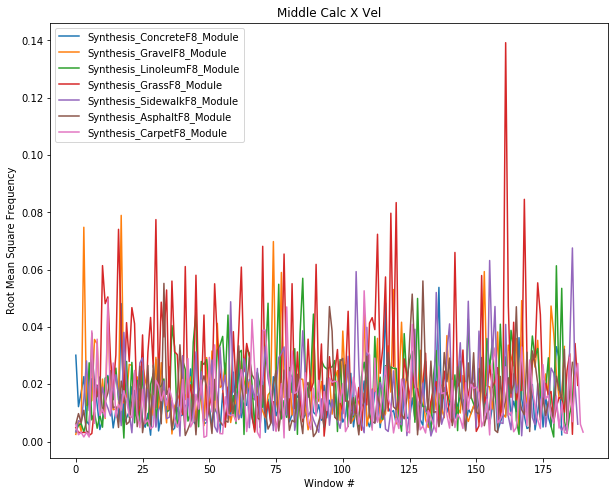

In [61]:
# Plot RMSF of Y Accel
feat_datasets_to_plot = {label: feature for label, feature in datasets_feat_freq.items() if 'Synthesis' in label and 'Straight' not in label and 'Donut' not in label}
plot_set_features(feat_datasets_to_plot, dirn='Calc X Vel', feat_name='Root Mean Square Frequency', placement_name='Middle')

#### Data Structure

`Terrain Dataset Dictionary
-> Direction Dictionary 
---> Pandas Array
-----> Row = Window #
-----> Col = Extracted Feature`

## Part 6 - Standardization, Columning, and Combining Datasets

**Since Z Gyro data is often cutoff out of range on old datasets, possible to get PSD of zero which results in NaN values**

This is likely the cause of some of the errors below

In [62]:
# Convert transformed data to Pandas
datasets_fft = np_to_pd(datasets_fft, windowed=True)
datasets_psd_log = np_to_pd(datasets_psd_log, windowed=True)

In [63]:
# Run to convert transformed data back to Numpy
#datasets_fft = pd_to_np(datasets_fft, windowed=True)
#datasets_psd_log = pd_to_np(datasets_psd_log, windowed=True)

In [64]:
# Add time and frequency features together
datasets_feat = {}

for label, dataset in datasets_feat_time.items():
    dataset_feat = {}
    
    for dirn_label, dirn_df in dataset.items():
        new_df = dirn_df.join(datasets_feat_freq[label][dirn_label], how='outer')
        dataset_feat.update({dirn_label: new_df})
    
    datasets_feat.update({label: dataset_feat})

In [65]:
# Confirm formatting
datasets_feat[dataset_labels[0]]['Calc X Accel'].head()

,Mean,Std Dev,L2 Norm,Autocorrelation,Max,Min,Root Mean Squared,Zero Crossing Rate,Skew,Excess Kurtosis,Mean Square Frequency,Root Mean Square Frequency,Frequency Center,Variance Frequency,Root Variance Frequency
0,0.527001,0.643394,15.176676,230.331489,3.828758,-2.335586,0.831677,0.048048,0.115235,5.417807,0.179779,0.424004,16.851437,-283.791151,0.424004
1,0.179620,1.627582,29.880903,892.868343,11.637356,-3.261605,1.637463,0.090090,2.709164,13.864961,1.262982,1.123825,19.323885,-372.149534,1.123825
2,0.374969,1.081074,20.880720,436.004454,1.904194,-7.453019,1.144256,0.069069,-2.499043,14.076757,0.280668,0.529781,13.210384,-174.233579,0.529781
3,-0.282004,0.660425,13.104348,171.723924,2.235415,-1.879207,0.718114,0.072072,1.049090,1.931687,0.162503,0.403117,13.312947,-177.072063,0.403117
4,0.013121,0.951992,17.373875,301.851520,3.338545,-2.505349,0.952082,0.036036,0.798081,1.062594,0.428886,0.654894,6.915922,-47.401093,0.654894


### Part (a) - Standardization

#### Standardize each feature to mean 0 and standard deviation 1. This makes feature selection and classification easier.

In [66]:
'''Normalize already featured datasets'''
def normalize_datasets(datasets, windowed=False):
    # Normalization function
    from sklearn.preprocessing import scale
    
    datasets_norm = {}
    
    # Go through windowed data (transforms) or dictionary data (features)
    for label, dataset in datasets.items():
        if windowed:
            dataset_norm = []
            for window_df in dataset:
                window_df = window_df.dropna()
                dataset_norm.append(window_df.apply(scale))
        else:
            dataset_norm = {}
            for dirn_label, dirn_df in dataset.items():
                dirn_df = dirn_df.dropna()
                dataset_norm.update({dirn_label: dirn_df.apply(sklearn.preprocessing.scale)})
        
        datasets_norm.update({label: dataset_norm})
    
    return datasets_norm

In [67]:
# So we can remove infinites
pd.set_option('use_inf_as_na', True)

datasets_feat_norm = normalize_datasets(datasets_feat)
datasets_fft_norm = normalize_datasets(datasets_fft, windowed=True)
datasets_psd_norm = normalize_datasets(datasets_psd_log, windowed=True)

In [68]:
datasets_feat_norm[dataset_labels[0]]['Calc X Accel'].head()

,Mean,Std Dev,L2 Norm,Autocorrelation,Max,Min,Root Mean Squared,Zero Crossing Rate,Skew,Excess Kurtosis,Mean Square Frequency,Root Mean Square Frequency,Frequency Center,Variance Frequency,Root Variance Frequency
0,2.708405,-0.838320,-0.131278,-0.240776,0.149080,0.454586,-0.131278,-1.111189,-0.337589,0.148072,-0.532860,-0.495809,0.907291,-0.790265,-0.495809
1,0.924306,3.382773,3.366948,4.353568,4.416146,-0.067942,3.366948,0.919386,2.165187,1.710178,5.115694,3.780102,1.471444,-1.494899,3.780102
2,1.927592,1.038848,1.225749,1.185457,-0.902611,-2.433046,1.225749,-0.095901,-2.860001,1.749345,-0.006759,0.150490,0.076490,0.083426,0.150490
3,-1.446538,-0.765278,-0.624297,-0.647189,-0.721613,0.712109,-0.624297,0.049140,0.563449,-0.496605,-0.622949,-0.623429,0.099892,0.060789,-0.623429
4,0.069185,0.485228,0.391449,0.255177,-0.118800,0.358794,0.391449,-1.691353,0.321261,-0.657323,0.766150,0.914930,-1.359755,1.094879,0.914930


<Figure size 432x288 with 0 Axes>

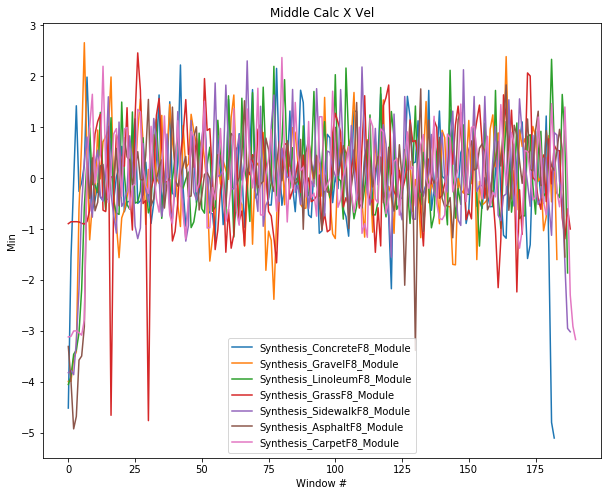

In [69]:
# Plot normalized features
feat_datasets_to_plot = {label: dataset for label, dataset in datasets_feat_norm.items() if 'Synthesis' in label in label and 'Power' not in label and 'Straight' not in label and 'Donut' not in label}
plot_set_features(feat_datasets_to_plot, dirn='Calc X Vel', feat_name='Min', placement_name='Middle')

/home/caris/anaconda2/envs/keenanm/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


<Figure size 432x288 with 0 Axes>

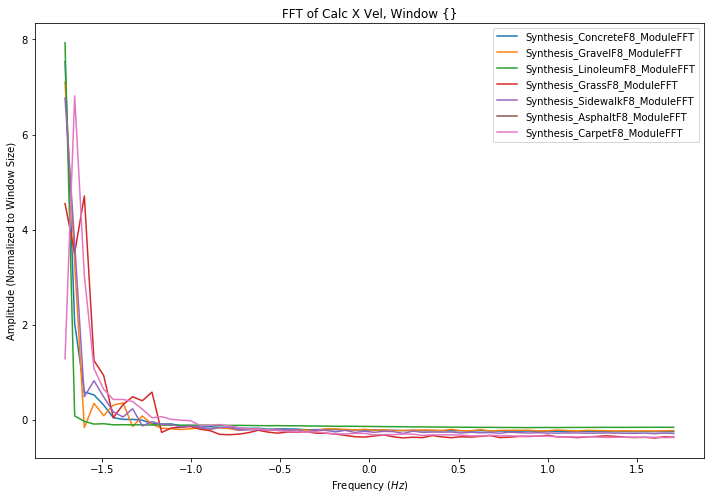

In [70]:
# Plot normalized fft
ffts_to_plot = {label: dataset for label, dataset in datasets_fft_norm.items() if 'Synthesis' in label and 'Straight' not in label and 'Donut' not in label}
plot_set_transforms(pd_to_np(ffts_to_plot, windowed=True), dirn=1, win_num=0, transform_name='FFT')

### Part (b) - Columning Data

#### Combine IMU data from each direction into single dataframes with columns for each feature in each direction

#### Part (i) - Extracted Featured Data

In [71]:
'''Append a tag to the end of every column name of a dataframe'''
def append_all_columns(columns, append_tag):
    new_columns = []
    
    for column in columns:
        new_columns.append(column + ' ' + append_tag)
    
    return new_columns

In [72]:
'''Combined directions of a featured dataset'''
def combine_columns(datasets):
    datasets_combined = {}
    
    for label, dataset in datasets.items():
        # Get labels array of first column
        df_combined = pd.DataFrame()
        
        # Append direction name to feature name and combine everything in one frame
        for dirn_label, dirn_df in dataset.items():
            df_copy = pd.DataFrame(dirn_df)
            
            # Add direction and placement tags
            df_copy.columns = append_all_columns(dirn_df.columns, dirn_label)
            df_copy.columns = append_all_columns(dirn_df.columns, get_placement(label))
            
            df_combined = df_combined.join(dirn_df, how='outer')
        
        datasets_combined.update({label: df_combined})
    
    return datasets_combined

In [73]:
# Take frame data and combine directions
datasets_feat_columned = combine_columns(datasets_feat_norm)

# Confirm formatting
datasets_feat_columned[dataset_labels[0]].head()

,Mean Calc X Accel Synthesis,Std Dev Calc X Accel Synthesis,L2 Norm Calc X Accel Synthesis,Autocorrelation Calc X Accel Synthesis,Max Calc X Accel Synthesis,Min Calc X Accel Synthesis,Root Mean Squared Calc X Accel Synthesis,Zero Crossing Rate Calc X Accel Synthesis,Skew Calc X Accel Synthesis,Excess Kurtosis Calc X Accel Synthesis,...,Min Right Z Gyro Synthesis,Root Mean Squared Right Z Gyro Synthesis,Zero Crossing Rate Right Z Gyro Synthesis,Skew Right Z Gyro Synthesis,Excess Kurtosis Right Z Gyro Synthesis,Mean Square Frequency Right Z Gyro Synthesis,Root Mean Square Frequency Right Z Gyro Synthesis,Frequency Center Right Z Gyro Synthesis,Variance Frequency Right Z Gyro Synthesis,Root Variance Frequency Right Z Gyro Synthesis
0,2.708405,-0.838320,-0.131278,-0.240776,0.149080,0.454586,-0.131278,-1.111189,-0.337589,0.148072,...,-0.615947,0.450066,-0.085379,0.546738,0.113777,-0.315774,-0.109462,-0.576031,0.575086,-0.109462
1,0.924306,3.382773,3.366948,4.353568,4.416146,-0.067942,3.366948,0.919386,2.165187,1.710178,...,-0.525065,0.595515,-0.085379,-0.365701,-0.729476,-0.694542,-0.893520,-0.873137,0.678485,-0.893520
2,1.927592,1.038848,1.225749,1.185457,-0.902611,-2.433046,1.225749,-0.095901,-2.860001,1.749345,...,-0.350206,-0.026356,-0.085379,-0.587548,-0.775718,0.944824,1.177976,1.040721,-0.758648,1.177976
3,-1.446538,-0.765278,-0.624297,-0.647189,-0.721613,0.712109,-0.624297,0.049140,0.563449,-0.496605,...,1.304861,-1.152855,-0.085379,-0.022611,-0.515084,-0.727757,-1.018696,-0.818202,0.662375,-1.018696
4,0.069185,0.485228,0.391449,0.255177,-0.118800,0.358794,0.391449,-1.691353,0.321261,-0.657323,...,1.449593,-1.299451,-0.085379,-1.588232,-0.497921,-0.654127,-0.769204,0.317595,-0.004542,-0.769204


#### Part (ii) - Transformed Data

In [74]:
'''Combined direction columns for transformed data'''
def combine_transform_columns(datasets):
    combined_datasets = {}
    
    for label, dataset in datasets.items():
        combined_windows = []
        
        for window in dataset:
            window_as_row = pd.DataFrame()
            
            # Turn each window 2D dataframe into a single row dataframe
            for row in window.iterrows():
                for data_column in get_columns(label)[:get_n_data_col(label)]:
                    combined_column_name = get_transform(label) + ' {} Hz '.format(round(row[1]['Frequency']))
                    combined_column_name +=  data_column + ' ' + get_placement(label)
                    window_as_row.insert(0, combined_column_name, [row[1][data_column]])
            
            combined_windows.append(window_as_row)
        
        # Combine all the single row dataframes into one dataframe
        combined_datasets.update({label: pd.concat(combined_windows, ignore_index=True)})
    
    return combined_datasets

In [75]:
datasets_fft_columned = combine_transform_columns(datasets_fft)

In [76]:
datasets_psd_log_columned = combine_transform_columns(datasets_psd_log)

In [77]:
# Check FFT data
datasets_fft_columned[dataset_labels[0] + 'FFT']

,FFT 63.0 Hz Right Z Gyro Synthesis,FFT 63.0 Hz Right Y Gyro Synthesis,FFT 63.0 Hz Right X Gyro Synthesis,FFT 63.0 Hz Right XY Accel Synthesis,FFT 63.0 Hz Right Z Accel Synthesis,FFT 63.0 Hz Right Y Accel Synthesis,FFT 63.0 Hz Right X Accel Synthesis,FFT 63.0 Hz Left Z Gyro Synthesis,FFT 63.0 Hz Left Y Gyro Synthesis,FFT 63.0 Hz Left X Gyro Synthesis,...,FFT 0.0 Hz Left Z Gyro Synthesis,FFT 0.0 Hz Left Y Gyro Synthesis,FFT 0.0 Hz Left X Gyro Synthesis,FFT 0.0 Hz Left XY Accel Synthesis,FFT 0.0 Hz Left Z Accel Synthesis,FFT 0.0 Hz Left Y Accel Synthesis,FFT 0.0 Hz Left X Accel Synthesis,FFT 0.0 Hz Calc Z Gyro Synthesis,FFT 0.0 Hz Calc X Vel Synthesis,FFT 0.0 Hz Calc X Accel Synthesis
0,0.001552,0.005220,0.000588,0.006084,0.043464,0.051385,0.029846,0.002904,0.001387,0.001877,...,0.533104,0.157169,0.678685,11.215207,0.401447,1.862471,10.975711,0.652687,0.326964,0.527001
1,0.001040,0.002563,0.000753,0.015377,0.019558,0.048466,0.019370,0.001657,0.001646,0.003583,...,1.410341,0.909568,0.321311,10.565753,0.151303,8.576828,5.031752,1.009245,0.678454,0.179620
2,0.005645,0.004441,0.000488,0.010428,0.004281,0.049837,0.014465,0.005798,0.003128,0.001365,...,2.709173,0.158856,0.261604,9.024437,0.041798,2.651643,5.499521,0.393991,0.901643,0.374969
3,0.000240,0.003612,0.004500,0.007753,0.007099,0.023736,0.023946,0.000410,0.003295,0.002185,...,3.925108,0.604421,0.157227,10.753048,1.443873,1.115116,6.163459,0.684785,0.979863,0.282004
4,0.000901,0.004457,0.001752,0.007245,0.011836,0.026304,0.013906,0.000699,0.003722,0.006424,...,3.926064,0.410444,0.380494,9.303403,2.632468,3.220118,1.697626,1.390480,0.796664,0.013121
5,0.006133,0.003614,0.003027,0.005586,0.009382,0.019953,0.045750,0.000339,0.002847,0.007323,...,3.791115,0.820844,0.313851,10.206626,1.774000,5.851872,0.157579,1.395298,0.755601,0.074692
6,0.002021,0.002300,0.001540,0.009254,0.012947,0.019185,0.054231,0.000089,0.004743,0.003362,...,3.906153,0.313883,0.303359,10.427965,2.196245,1.816355,5.897486,1.131809,0.858045,0.336925
7,0.001354,0.006108,0.002050,0.006534,0.008166,0.047702,0.015905,0.005429,0.001791,0.000228,...,3.162247,0.558697,0.144524,9.042308,0.156243,0.781169,4.549555,0.373615,1.030003,0.172686
8,0.000081,0.006478,0.002677,0.019083,0.018121,0.040820,0.034602,0.002131,0.003463,0.004018,...,1.599389,0.862559,0.924727,10.741640,0.224404,5.728394,8.082522,1.350222,0.822878,0.157344
9,0.000970,0.002649,0.005215,0.012921,0.023595,0.030076,0.061000,0.000789,0.003021,0.003337,...,1.424231,0.680544,1.092781,11.042591,0.110932,5.220055,9.031844,1.390450,0.781665,0.037668


In [78]:
# Check PSD data
datasets_psd_log_columned[dataset_labels[0] + 'PSDLog']

,PSD 63.0 Hz Right Z Gyro Synthesis,PSD 63.0 Hz Right Y Gyro Synthesis,PSD 63.0 Hz Right X Gyro Synthesis,PSD 63.0 Hz Right XY Accel Synthesis,PSD 63.0 Hz Right Z Accel Synthesis,PSD 63.0 Hz Right Y Accel Synthesis,PSD 63.0 Hz Right X Accel Synthesis,PSD 63.0 Hz Left Z Gyro Synthesis,PSD 63.0 Hz Left Y Gyro Synthesis,PSD 63.0 Hz Left X Gyro Synthesis,...,PSD 0.0 Hz Left Z Gyro Synthesis,PSD 0.0 Hz Left Y Gyro Synthesis,PSD 0.0 Hz Left X Gyro Synthesis,PSD 0.0 Hz Left XY Accel Synthesis,PSD 0.0 Hz Left Z Accel Synthesis,PSD 0.0 Hz Left Y Accel Synthesis,PSD 0.0 Hz Left X Accel Synthesis,PSD 0.0 Hz Calc Z Gyro Synthesis,PSD 0.0 Hz Calc X Vel Synthesis,PSD 0.0 Hz Calc X Accel Synthesis
0,-5.281415,-4.261513,-5.575417,-3.835856,-3.394549,-2.295725,-3.811792,-4.780678,-5.538217,-5.273762,...,-1.151405,-1.953336,-1.361905,-3.171946,-2.400297,-0.084784,-1.256088,-1.236733,-1.729037,-1.800077
1,-5.684426,-4.915317,-5.761391,-5.061290,-3.251479,-2.332028,-2.887437,-5.388989,-5.155453,-5.040347,...,-1.848586,-0.899782,-1.400691,-0.969433,-1.492893,0.119195,0.752094,-1.164648,-2.061017,-0.951975
2,-4.230694,-4.486565,-6.276659,-3.971664,-3.568522,-2.410626,-3.287966,-4.183779,-4.857534,-5.209148,...,-0.188347,-0.967851,-1.408537,-1.154770,-0.868359,1.377453,0.663760,-1.043423,-1.584544,-0.560637
3,-6.872225,-4.685381,-4.558596,-3.210780,-2.562270,-2.855260,-3.089417,-6.454103,-4.732217,-4.753878,...,-1.162928,-0.519375,-1.000046,-0.470285,-1.474466,1.616320,1.284219,-0.758110,-2.744564,-1.405611
4,-5.729411,-4.425198,-5.029313,-4.153745,-3.470432,-2.816423,-3.398452,-6.111358,-4.582600,-4.177254,...,-0.806667,-0.310541,-0.086820,-0.376253,-0.227638,1.318372,1.561800,-1.691188,-2.194934,-0.626575
5,-4.117506,-4.514882,-4.631298,-3.766729,-3.398045,-3.226582,-2.371521,-6.826878,-4.738546,-4.026329,...,-1.062114,-0.445807,-0.037012,-0.039713,-0.353560,1.246559,1.570618,-1.546154,-2.605334,-0.952075
6,-5.103603,-5.098734,-5.816833,-4.170541,-2.946932,-3.719612,-2.429100,-6.898801,-4.446886,-4.638330,...,-1.208776,-0.290694,-0.521883,-0.128341,-0.211700,1.522624,1.339118,-1.036332,-1.902372,-0.643650
7,-5.482224,-4.110547,-5.450043,-4.547379,-3.227914,-2.356861,-3.594520,-4.223798,-5.196460,-6.289372,...,-0.661551,-0.918781,-1.190413,-0.487305,-1.577216,1.578073,0.937250,-0.671976,-3.332337,-1.752057
8,-7.005101,-4.118849,-4.939013,-4.530225,-2.954923,-2.480564,-2.672739,-5.008817,-4.657536,-4.443383,...,-1.637153,-1.130475,-0.787355,-0.932712,-1.796263,0.778162,0.697930,-1.692035,-2.735441,-1.024972
9,-5.727681,-4.924974,-4.319254,-4.657830,-2.879074,-3.039111,-2.097575,-5.730741,-4.567177,-4.544862,...,-1.071982,-0.931656,-1.370392,-1.345981,-1.207152,0.650165,0.487530,-2.221329,-1.980877,-0.457537


### Part (c) - Adding Labels

Create a new column containg the an integer label for each terrain.

In [79]:
'Add labels to a dataset'
def insert_labels(datasets):
    # Returns new datasets
    datasets_copy = {}
    
    # Add to each dataframe of a dataset
    for label, dataset in datasets.items():
        terrain_num = get_terrain_num(label)
        labels = [terrain_num for _ in range(len(dataset))]
        
        dataset_copy = dataset.copy()
        dataset_copy.insert(0, 'Label', labels)
        
        datasets_copy.update({label: dataset_copy})
    
    return datasets_copy

In [80]:
# Add labels
datasets_feat_columned = insert_labels(datasets_feat_columned)
datasets_fft_columned = insert_labels(datasets_fft_columned)
datasets_psd_log_columned = insert_labels(datasets_psd_log_columned)

In [81]:
# Check labelled feature data
datasets_feat_columned[dataset_labels[0]].head()

,Label,Mean Calc X Accel Synthesis,Std Dev Calc X Accel Synthesis,L2 Norm Calc X Accel Synthesis,Autocorrelation Calc X Accel Synthesis,Max Calc X Accel Synthesis,Min Calc X Accel Synthesis,Root Mean Squared Calc X Accel Synthesis,Zero Crossing Rate Calc X Accel Synthesis,Skew Calc X Accel Synthesis,...,Min Right Z Gyro Synthesis,Root Mean Squared Right Z Gyro Synthesis,Zero Crossing Rate Right Z Gyro Synthesis,Skew Right Z Gyro Synthesis,Excess Kurtosis Right Z Gyro Synthesis,Mean Square Frequency Right Z Gyro Synthesis,Root Mean Square Frequency Right Z Gyro Synthesis,Frequency Center Right Z Gyro Synthesis,Variance Frequency Right Z Gyro Synthesis,Root Variance Frequency Right Z Gyro Synthesis
0,0,2.708405,-0.838320,-0.131278,-0.240776,0.149080,0.454586,-0.131278,-1.111189,-0.337589,...,-0.615947,0.450066,-0.085379,0.546738,0.113777,-0.315774,-0.109462,-0.576031,0.575086,-0.109462
1,0,0.924306,3.382773,3.366948,4.353568,4.416146,-0.067942,3.366948,0.919386,2.165187,...,-0.525065,0.595515,-0.085379,-0.365701,-0.729476,-0.694542,-0.893520,-0.873137,0.678485,-0.893520
2,0,1.927592,1.038848,1.225749,1.185457,-0.902611,-2.433046,1.225749,-0.095901,-2.860001,...,-0.350206,-0.026356,-0.085379,-0.587548,-0.775718,0.944824,1.177976,1.040721,-0.758648,1.177976
3,0,-1.446538,-0.765278,-0.624297,-0.647189,-0.721613,0.712109,-0.624297,0.049140,0.563449,...,1.304861,-1.152855,-0.085379,-0.022611,-0.515084,-0.727757,-1.018696,-0.818202,0.662375,-1.018696
4,0,0.069185,0.485228,0.391449,0.255177,-0.118800,0.358794,0.391449,-1.691353,0.321261,...,1.449593,-1.299451,-0.085379,-1.588232,-0.497921,-0.654127,-0.769204,0.317595,-0.004542,-0.769204


In [82]:
# Check labelled FFT data
datasets_fft_columned[dataset_labels[0] + 'FFT'].head()

,Label,FFT 63.0 Hz Right Z Gyro Synthesis,FFT 63.0 Hz Right Y Gyro Synthesis,FFT 63.0 Hz Right X Gyro Synthesis,FFT 63.0 Hz Right XY Accel Synthesis,FFT 63.0 Hz Right Z Accel Synthesis,FFT 63.0 Hz Right Y Accel Synthesis,FFT 63.0 Hz Right X Accel Synthesis,FFT 63.0 Hz Left Z Gyro Synthesis,FFT 63.0 Hz Left Y Gyro Synthesis,...,FFT 0.0 Hz Left Z Gyro Synthesis,FFT 0.0 Hz Left Y Gyro Synthesis,FFT 0.0 Hz Left X Gyro Synthesis,FFT 0.0 Hz Left XY Accel Synthesis,FFT 0.0 Hz Left Z Accel Synthesis,FFT 0.0 Hz Left Y Accel Synthesis,FFT 0.0 Hz Left X Accel Synthesis,FFT 0.0 Hz Calc Z Gyro Synthesis,FFT 0.0 Hz Calc X Vel Synthesis,FFT 0.0 Hz Calc X Accel Synthesis
0,0,0.001552,0.005220,0.000588,0.006084,0.043464,0.051385,0.029846,0.002904,0.001387,...,0.533104,0.157169,0.678685,11.215207,0.401447,1.862471,10.975711,0.652687,0.326964,0.527001
1,0,0.001040,0.002563,0.000753,0.015377,0.019558,0.048466,0.019370,0.001657,0.001646,...,1.410341,0.909568,0.321311,10.565753,0.151303,8.576828,5.031752,1.009245,0.678454,0.179620
2,0,0.005645,0.004441,0.000488,0.010428,0.004281,0.049837,0.014465,0.005798,0.003128,...,2.709173,0.158856,0.261604,9.024437,0.041798,2.651643,5.499521,0.393991,0.901643,0.374969
3,0,0.000240,0.003612,0.004500,0.007753,0.007099,0.023736,0.023946,0.000410,0.003295,...,3.925108,0.604421,0.157227,10.753048,1.443873,1.115116,6.163459,0.684785,0.979863,0.282004
4,0,0.000901,0.004457,0.001752,0.007245,0.011836,0.026304,0.013906,0.000699,0.003722,...,3.926064,0.410444,0.380494,9.303403,2.632468,3.220118,1.697626,1.390480,0.796664,0.013121


### Part (d) - Combining Datasets

Combine data from every dataset into rows in a single dataframe

In [83]:
'''Combine data from labelled datasets into a single dataframe'''
def combine_datasets(datasets):
    return pd.concat(list(datasets.values()), ignore_index=True)

In [84]:
# Combine all data individually
# TODO: Combine each mounting source of a single dataset into a single dataframe so we can select across all
def separate_and_combine(datasets_columned, csv_tag):
    datasets_separated = {}
    
    # Separate according to mounting location
    for placement in placements:
        datasets = {label: dataset for label, dataset in datasets_columned.items() if placement in label}
        
        # Update if not empty
        if bool(datasets): 
            datasets_separated.update({placement: datasets})
    
    # Combine each mounting into a single combined dataframe and drop NaN values, export to csv
    for placement, datasets in datasets_separated.items():
        # NaN values usually come from cutoff range of Z gyro, so drop the column
        datasets_separated.update({placement: combine_datasets(datasets).dropna(axis='columns')})
        
        # Export to a csv file
        csv_filename = 'processed_data/' + placement + '_' + csv_tag + '.csv'
        datasets_separated[placement].to_csv(csv_filename, index=False)
                        
    # Return dictionary of each mounting location
    return datasets_separated

In [85]:
# Convert features
feat_combined = separate_and_combine(datasets_feat_columned, csv_tag='Features_Filt_Keenan')

feat_combined['Synthesis'].tail()

,Label,Mean Calc X Vel Synthesis,Std Dev Calc X Vel Synthesis,L2 Norm Calc X Vel Synthesis,Autocorrelation Calc X Vel Synthesis,Max Calc X Vel Synthesis,Min Calc X Vel Synthesis,Root Mean Squared Calc X Vel Synthesis,Zero Crossing Rate Calc X Vel Synthesis,Skew Calc X Vel Synthesis,...,Min Right Z Gyro Synthesis,Root Mean Squared Right Z Gyro Synthesis,Zero Crossing Rate Right Z Gyro Synthesis,Skew Right Z Gyro Synthesis,Excess Kurtosis Right Z Gyro Synthesis,Mean Square Frequency Right Z Gyro Synthesis,Root Mean Square Frequency Right Z Gyro Synthesis,Frequency Center Right Z Gyro Synthesis,Variance Frequency Right Z Gyro Synthesis,Root Variance Frequency Right Z Gyro Synthesis
2375,1,0.740972,-0.640826,0.736409,0.757424,0.635888,0.970252,0.736409,-0.165521,0.415290,...,-0.375944,0.441580,-0.345547,-0.596165,-0.258579,-0.230421,-0.046355,1.482868,-1.153998,-0.046355
2376,1,-0.069591,0.279928,-0.096436,-0.352689,-0.160407,-0.338268,-0.096436,-0.165521,-0.946575,...,0.525082,-0.740383,-0.345547,0.316413,-0.618088,0.343136,0.860014,0.900980,-0.504468,0.860014
2377,1,-1.904279,0.677920,-1.839593,-1.592723,-1.679708,-1.869327,-1.839593,2.317296,0.973679,...,2.370772,-2.388279,-0.345547,-2.037384,1.456830,-0.421061,-0.647657,0.114605,0.128264,-0.647657
2378,1,-2.433078,-1.841804,-2.241272,-1.670593,-3.312200,-1.897103,-2.241272,-0.165521,0.009825,...,2.889266,-2.508473,-0.345547,0.727958,-0.402097,-0.454908,-0.888135,0.353243,-0.040584,-0.888135
2379,1,-2.352115,-1.697299,-2.311491,-1.676211,-3.161655,-1.814880,-2.311491,7.282932,1.129924,...,3.099228,-2.703564,4.837663,-1.564842,0.829064,-0.457672,-0.921266,-0.273789,0.351350,-0.921266


In [86]:
# Convert features
fft_combined = separate_and_combine(datasets_fft_columned, csv_tag='FFTs_Filt_Keenan')

fft_combined['Synthesis'].tail()

,Label,FFT 63.0 Hz Right Z Gyro Synthesis,FFT 63.0 Hz Right Y Gyro Synthesis,FFT 63.0 Hz Right X Gyro Synthesis,FFT 63.0 Hz Right XY Accel Synthesis,FFT 63.0 Hz Right Z Accel Synthesis,FFT 63.0 Hz Right Y Accel Synthesis,FFT 63.0 Hz Right X Accel Synthesis,FFT 63.0 Hz Left Z Gyro Synthesis,FFT 63.0 Hz Left Y Gyro Synthesis,...,FFT 0.0 Hz Right X Accel Synthesis,FFT 0.0 Hz Left Z Gyro Synthesis,FFT 0.0 Hz Left Y Gyro Synthesis,FFT 0.0 Hz Left X Gyro Synthesis,FFT 0.0 Hz Left XY Accel Synthesis,FFT 0.0 Hz Left Z Accel Synthesis,FFT 0.0 Hz Left Y Accel Synthesis,FFT 0.0 Hz Left X Accel Synthesis,FFT 0.0 Hz Calc Z Gyro Synthesis,FFT 0.0 Hz Calc X Vel Synthesis
2375,1,0.004112,0.000523,0.001009,0.037216,0.007496,0.011409,0.013348,0.002944,0.002156,...,2.759347,5.438349,0.283372,0.100363,10.013772,0.585897,2.523268,1.380750,0.056431,1.589641
2376,1,0.008035,0.000558,0.000270,0.020656,0.017920,0.013531,0.058425,0.006752,0.000591,...,1.280758,4.103505,0.157974,0.008636,9.993359,1.082060,0.744158,4.287426,0.199588,1.158641
2377,1,0.002411,0.000334,0.002267,0.003228,0.005438,0.006862,0.001861,0.009341,0.002492,...,10.635877,0.373704,0.262843,0.052599,9.751529,0.136728,9.487446,1.845199,0.280160,0.183084
2378,1,0.000832,0.000307,0.001411,0.002759,0.000916,0.010905,0.002042,0.000806,0.001229,...,10.269093,1.057488,0.732596,0.397785,10.338540,0.520243,7.865185,5.762848,0.822560,0.098094
2379,1,0.000083,0.000783,0.001271,0.001624,0.010162,0.002277,0.001257,0.002201,0.000953,...,9.780488,0.462841,0.096995,0.290100,10.610705,0.666737,1.475830,10.373245,0.313442,0.055043


In [87]:
# Convert features
psd_log_combined = separate_and_combine(datasets_psd_log_columned, csv_tag='PSDLogs_Filt_Keenan')

psd_log_combined['Synthesis'].tail()

,Label,PSD 63.0 Hz Right Z Gyro Synthesis,PSD 63.0 Hz Right Y Gyro Synthesis,PSD 63.0 Hz Right X Gyro Synthesis,PSD 63.0 Hz Right XY Accel Synthesis,PSD 63.0 Hz Right Z Accel Synthesis,PSD 63.0 Hz Right Y Accel Synthesis,PSD 63.0 Hz Right X Accel Synthesis,PSD 63.0 Hz Left Z Gyro Synthesis,PSD 63.0 Hz Left Y Gyro Synthesis,...,PSD 0.0 Hz Right X Accel Synthesis,PSD 0.0 Hz Left Z Gyro Synthesis,PSD 0.0 Hz Left Y Gyro Synthesis,PSD 0.0 Hz Left X Gyro Synthesis,PSD 0.0 Hz Left XY Accel Synthesis,PSD 0.0 Hz Left Z Accel Synthesis,PSD 0.0 Hz Left Y Accel Synthesis,PSD 0.0 Hz Left X Accel Synthesis,PSD 0.0 Hz Calc Z Gyro Synthesis,PSD 0.0 Hz Calc X Vel Synthesis
2375,1,-4.495223,-6.047405,-6.106408,-2.467171,-2.298876,-2.761441,-2.912814,-5.045367,-5.616711,...,1.574943,-0.956972,-4.082539,-2.906856,-0.142419,-0.788275,1.627912,1.667446,-2.745839,-1.929566
2376,1,-3.911631,-6.463445,-6.518997,-3.128950,-4.636320,-3.543720,-2.218974,-4.080461,-5.951950,...,1.549567,-0.520059,-2.058282,-1.965317,-0.219414,-0.823429,1.613208,1.473980,-3.347158,-1.602455
2377,1,-4.936952,-6.604392,-5.001386,-4.519630,-4.332104,-3.890610,-5.355674,-3.765989,-4.930646,...,-2.325974,-0.240679,-1.615635,-2.711689,-1.526973,-2.672274,-0.978111,0.060562,-1.699249,-1.456727
2378,1,-5.868955,-6.647698,-5.363829,-5.073543,-5.806574,-3.714434,-5.798405,-5.908815,-5.531499,...,-1.218804,-1.576878,-1.349941,-1.583133,-1.635720,-2.529799,0.325195,0.745436,-1.845138,-3.393197
2379,1,-7.832123,-6.283339,-5.337645,-4.907210,-3.809189,-4.913810,-4.714493,-5.041756,-5.648550,...,-2.926572,-1.179425,-2.204141,-1.592696,-4.695747,-2.538361,0.304483,-1.210629,-1.544212,-2.977139


### Glossary

`Dataset` - Batch of data recorded on one terrain type

`Data Window` - Split up portion of a `Dataset`

`Direction / Axes` - Linear acceleration or gyroscope in $x,y$ or $z$

`Feature Vector` - Any feature of the data that can be used to classify terrain, e.g. Z Accel Mean, Y Accel FFT, etc

`Extracted Feature Vector` - Features that aren't from transforms, e.g. Z Accel Min, Y Accel Autocorrelation, etc

`Placement` - One of three IMU placements on the wheelchair, i.e. Middle, Left, or Right